In [49]:
import os
import numpy as np
import numpy.random as npr
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
#plt.switch_backend('agg')

from scipy.integrate import odeint

keras = tf.keras
tf.compat.v1.enable_eager_execution()

#from neural_ode import NeuralODE

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline

In [50]:
def SIR(z, t, beta, gamma):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta * I * S / N - gamma * I
    dR = gamma * I 

    dzdt = [dS, dI, dR]
    return dzdt

def SIR_diffparam(z, t, beta, beta2, gamma, gamma2, errato = 0):

    S, I, R = z

    dS = - beta * I * S / N 
    dI = beta2 * I * S / N - gamma * I
    dR = gamma2 * I 

    dzdt = [dS, dI, dR]
    return dzdt

# adattare il modello tempo-variabile -> così da considerare lockdown ecc? -> o con alcuni threshold

def plot_traj(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    i = plt.plot(x2, linewidth = width, label = 'Infected')
    r = plt.plot(x3, linewidth = width, label = 'Removed')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Simulation with R0 = %f' %R0 )
    
    
def plot_traj_gray(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    s = plt.plot(x1, linewidth = width, color = 'lightgray')
    i = plt.plot(x2, linewidth = width, color = 'lightgray')
    r = plt.plot(x3, linewidth = width, color = 'lightgray')

In [51]:
# oop con ereditarietà?

def SEIR(z, t, beta, gamma, lamb, mu, a):

    S, E, I, R = z

    dS = - beta * I * S / N 
    dE = beta * I * S / N - a * E
    dI = a * E - gamma  * I
    dR = gamma * I 

    dzdt = [dS, dE, dI, dR]
    return dzdt

def plot_traj_SEIR(trajectories, width = 1.):
    x1 = trajectories[:,0]
    x2 = trajectories[:,1]
    x3 = trajectories[:,2]
    x4 = trajectories[:,3]
    
    s = plt.plot(x1, linewidth = width, label = 'Susceptible')
    r = plt.plot(x2, linewidth = width, label = 'Exposed')
    i = plt.plot(x3, linewidth = width, label = 'Infected')
    r = plt.plot(x4, linewidth = width, label = 'Removed')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.title('Simulation with R0 = %f' %(a*beta/gamma) )
    plt.show()

In [304]:
data_size = 100

batch_time = 20  # tempo delle batches
niters = 500
#batch_size = 84  # dimensione delle batches
batch_size = data_size - batch_time - 1

N = 60000
infected_0 = 100
beta = 0.3 # farli time evolving?
gamma = 0.1

R0 = beta/gamma

In [197]:
t_grid = np.linspace(0, data_size-1, data_size)  # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [N - infected_0, infected_0, 0] # initial conditions
true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento

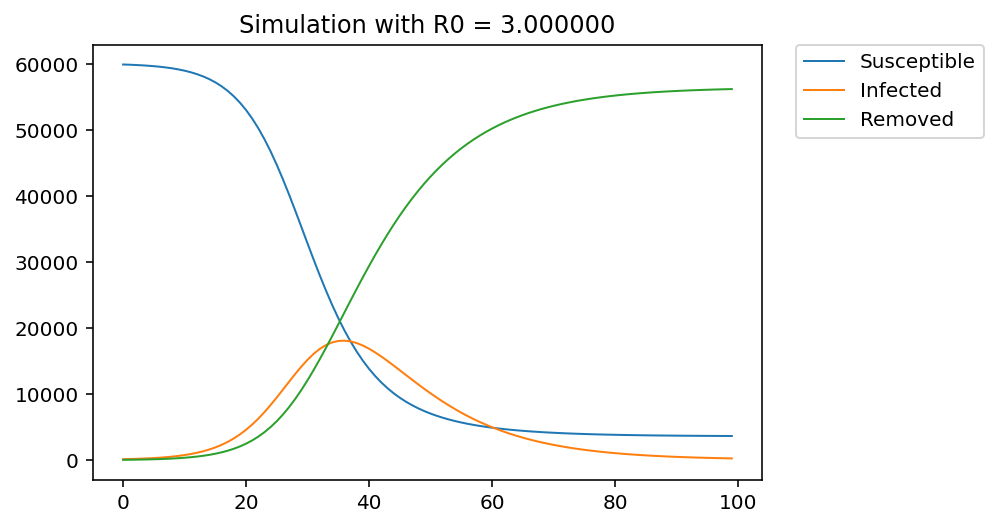

In [198]:
plot_traj(true_yy)

In [244]:

true_y = true_yy.copy()



from stochastic.processes.continuous import FractionalBrownianMotion

fbm = FractionalBrownianMotion(hurst=0.2, t= data_size)
# in questo modo è autocorrelato negativamente -> giorno da tanti tamponi seguito da giorno da pochi tamponi

noise = abs(N/200 * fbm.sample(data_size-1))
noise_2 = abs(N/200 * fbm.sample(data_size-1))


true_y[:,0] = abs(true_y[:,0] - noise)        
true_y[:,1] = abs(true_y[:,1] + noise - noise_2)
true_y[:,2] = N - true_y[:,0] - true_y[:,1]

# problema in realtà è che i suscettibili e i rimossi possono crescere/decrescere




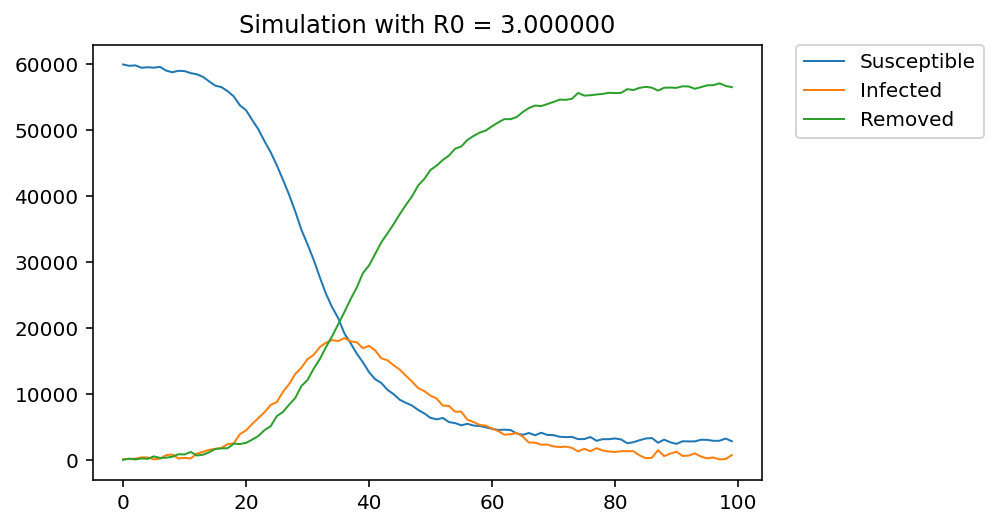

In [245]:
#true_y = true_yy
plot_traj(true_y)

In [246]:
sigma_s = np.std(true_y[:,0:1])  
sigma_i = np.std(true_y[:,1:2]) 
sigma_r = np.std(true_y[:,2:3]) 

true_y[:, 0:1] = true_y[:, 0:1]/sigma_s
true_y[:, 1:2] = true_y[:, 1:2]/sigma_i
true_y[:, 2:3] = true_y[:, 2:3]/sigma_r

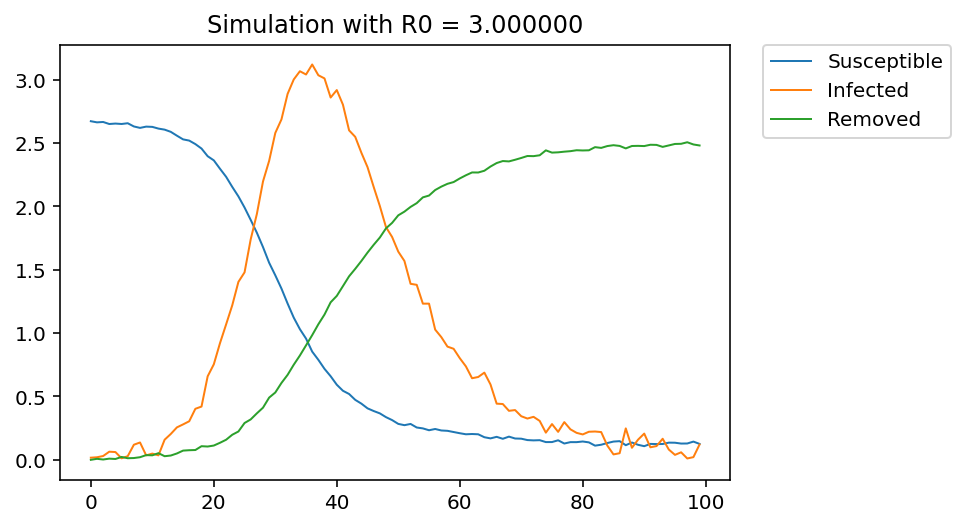

In [247]:
plot_traj(true_y)

In [248]:
def get_batch():
    """Returns initial point and last point over sampled frament of trajectory"""
    starts = np.random.choice(np.arange(data_size - batch_time - 1, dtype=np.int64), batch_size, replace=False)
    # This randomly chooses from {0, 1, ... , data_size - batch_time - 1}, batch_size different elements
    batch_y0 = true_y[starts] 
    batch_yN = true_y[starts + batch_time]
    # The function returns a tensor composed by some y0 and the respective yN,
    # being y0 + DeltaT.
    return tf.cast(batch_y0, dtype=tf.float32), tf.cast(batch_yN, dtype=tf.float32)

In [305]:
num_param = 5 # Number of parameters
para_num = num_param

t0 = t_grid[:batch_time][0]  # t0 = first element of t_grid
t1 = t_grid[:batch_time][-1]  # t1 = the element of t_grid at batch_time
t_in = np.linspace(t0, t1, 10)  # The time grid between t0 and t1

batch_y0, batch_yN = get_batch()  # Returns the first and the last y observed for each batch



In [255]:
from neural_ode import NeuralODE

In [306]:
batch_y0

<tf.Tensor: shape=(79, 3), dtype=float32, numpy=
array([[2.01678962e-01, 6.53761387e-01, 2.26765203e+00],
       [2.43414655e-01, 1.02785385e+00, 2.12930870e+00],
       [1.55067250e-01, 3.07193518e-01, 2.40364242e+00],
       [2.62984657e+00, 3.52611914e-02, 3.72157730e-02],
       [2.23384929e+00, 1.06884265e+00, 1.58513144e-01],
       [1.89357626e+00, 1.74040806e+00, 3.19038033e-01],
       [4.43485737e-01, 2.42351413e+00, 1.56948948e+00],
       [2.07917118e+00, 1.40438128e+00, 2.23615825e-01],
       [9.56766367e-01, 3.04123330e+00, 9.03448582e-01],
       [2.52920651e+00, 2.79650450e-01, 7.27966502e-02],
       [1.40243590e-01, 2.82326609e-01, 2.42470455e+00],
       [2.49196243e+00, 4.02832776e-01, 7.74535909e-02],
       [1.35178423e+00, 2.68669152e+00, 6.06603682e-01],
       [2.10042864e-01, 8.02536249e-01, 2.22074246e+00],
       [2.03782737e-01, 6.43956840e-01, 2.26812887e+00],
       [2.36345458e+00, 7.53910124e-01, 1.12745129e-01],
       [3.13555717e-01, 1.75856042e+00,

In [256]:
niters_pre = 500  # Number of iterations of the preconditioner

class ODEModel_pre(tf.keras.Model):
    def __init__(self):
        super(ODEModel_pre, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
    # Initializer: assign normally distributed random weights which are very close to zero

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]
        p5 = self.Weights[4]

        dS = - p1 * I * S / N + p5 * R 
        dI = p2 * I * S / N - p3 * I 
        dR = p4 * I - p5 * R
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model_pre = ODEModel_pre()  
neural_ode_pre = NeuralODE(model_pre, t_in) 
optimizer = tf.compat.v1.train.AdamOptimizer(3e-2)  

In [257]:
@tf.function
def compute_gradients_and_update_pre(batch_y0, batch_yN):
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode_pre.forward(batch_y0)  # Predict y using Runge-Kutta 4 for each y0 in batch_y0
    with tf.GradientTape() as g_pre:
        g_pre.watch(pred_y)
        loss = tf.reduce_mean(input_tensor=(pred_y - batch_yN)**2) + tf.reduce_sum(input_tensor=tf.abs(model_pre.trainable_weights[0]))
        # This step is computing the loss function
    dLoss = g_pre.gradient(loss, pred_y)  # Here we compute the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode_pre.backward(pred_y, dLoss)  # Here we compute the dWeights
    optimizer.apply_gradients(zip(dWeights, model_pre.weights))  # Here we update the weights
    return loss, dWeights

#parameters_pre = np.zeros((para_num, niters_pre))
parameters_pre = np.zeros((para_num, 1))

for step in tqdm(range(niters_pre)):
    loss, dWeights = compute_gradients_and_update_pre(batch_y0, batch_yN)
    #parameters_pre[:,step] = np.reshape(model_pre.trainable_weights[0].numpy(),(5,))
    parameters_pre = model_pre.trainable_weights[0].numpy()
print(parameters_pre)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:01<00:00,  8.17it/s]

[[ 3.37705374e-01]
 [ 3.26519638e-01]
 [ 1.05096094e-01]
 [ 1.05685808e-01]
 [-1.71104854e-04]]


In [259]:
initial_weight = parameters_pre  # We initialize the weights with the parameters found in preconditioning
print(initial_weight.shape, "here")


class ODEModel(tf.keras.Model):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.Weights = tf.Variable(tf.random.normal([num_param, 1], dtype=tf.float32)*0.01, dtype=tf.float32)
        # Initializer, initializes the weight to normal random variables with sd = 0.01

    def call(self, inputs, **kwargs):
        t, y = inputs
        h = y
        S = h[:, 0:1] * sigma_s
        I = h[:, 1:2] * sigma_i
        R = h[:, 2:3] * sigma_r
        

        # ma che sintassi di merda -> facciamolo adattativo

        p1 = self.Weights[0]
        p2 = self.Weights[1]
        p3 = self.Weights[2]
        p4 = self.Weights[3]
        p5 = self.Weights[4]

        dS = - p1 * I * S / N + p5 * R 
        dI = p2 * I * S / N - p3 * I 
        dR = p4 * I - p5 * R
        
        h_out = tf.concat([dS/sigma_s, dI/sigma_i, dR/sigma_r], 1)
        return h_out


model = ODEModel()
neural_ode = NeuralODE(model, t=t_in)  # We assign to NeuralODE the just created model and the time grid  between t0 and t1

@tf.function
def compute_gradients_and_update(batch_y0, batch_yN): 
    """Takes start positions (x0, y0) and final positions (xN, yN)"""
    pred_y = neural_ode.forward(batch_y0)  # This finds the predicted yNs
    with tf.GradientTape() as g:
        g.watch(pred_y)
        loss = tf.reduce_sum(input_tensor=(pred_y - batch_yN)**2)  # This creates the loss function

    dLoss = g.gradient(loss, pred_y)  # This computes the gradient of the loss function
    h_start, dfdh0, dWeights = neural_ode.backward(pred_y, dLoss)  # This applies the gradient descent to find
    # the updates for the weights

    return loss, dWeights

(5, 1) here


In [260]:
def kinetic_energy(V, loggamma_v, loglambda_v):
    q = (np.sum(-V**2)/mom_theta - loggamma_v**2/mom_gamma - loglambda_v**2/mom_lambda)/2.0
    return q


def compute_gradient_param(dWeights, loggamma, loglambda, batch_size, para_num):
    WW = model.trainable_weights[0].numpy()
    dWeights = np.exp(loggamma)/2.0 * dWeights + np.exp(loglambda) * np.sign(WW - w_means)
    return dWeights


def compute_gradient_hyper(loss, weights, loggamma, loglambda, batch_size, para_num):
    grad_loggamma = np.exp(loggamma) * (loss/2.0 + 1.0) - (batch_size/2.0 + 1.0)
    grad_loglambda = np.exp(loglambda) * (np.sum(np.abs(weights - w_means)) + 1.0) - (para_num + 1.0)
    # This somehow computes the gradient of the hyper parameters in order to update them from step to step

    return grad_loggamma, grad_loglambda


def compute_Hamiltonian(loss, weights, loggamma, loglambda, batch_size, para_num):
    H = np.exp(loggamma)*(loss/2.0 + 1.0) + np.exp(loglambda)*(np.sum(np.abs(weights - w_means)) + 1.0) \
             - (batch_size/2.0 + 1.0) * loggamma - (para_num + 1.0) * loglambda
    return H

def leap_frog(v_in, w_in, loggamma_in, loglambda_in, loggamma_v_in, loglambda_v_in):
    # Leap frog step for Hamiltonian Monte Carlo

    model.trainable_weights[0].assign(w_in)
    v_new = v_in
    loggamma_v_new = loggamma_v_in
    loglambda_v_new = loglambda_v_in

    loggamma_new = loggamma_in
    loglambda_new = loglambda_in
    w_new = w_in

    for m in range(L):
        loss, dWeights = compute_gradients_and_update(batch_y0, batch_yN) # evaluate the gradient

        dWeights = np.asarray(dWeights[0])  # make the gradient to be numpy array
        dWeights = compute_gradient_param(dWeights, loggamma_new, loglambda_new, batch_size, para_num)
        grad_loggamma, grad_loglambda = compute_gradient_hyper(loss, w_new, loggamma_new, loglambda_new, batch_size, para_num)

        loggamma_v_new = loggamma_v_new - epsilon/2*grad_loggamma  # Computation of new velocities
        loglambda_v_new = loglambda_v_new - epsilon/2*grad_loglambda  # 2nd component of velocity
        v_new = v_new - epsilon/2*(dWeights)  # 3rd component of velocity
        w_new = model.trainable_weights[0].numpy() + epsilon / mom_theta * v_new  # updating of x_1
        model.trainable_weights[0].assign(w_new)  # Assignment
        loggamma_new = loggamma_new + epsilon / mom_gamma * loggamma_v_new  # Updating of x_2
        loglambda_new = loglambda_new + epsilon / mom_lambda * loglambda_v_new  # Updating of x_3

        # Second half of the leap frog
        loss, dWeights = compute_gradients_and_update(batch_y0, batch_yN)
        dWeights = np.asarray(dWeights[0])
        dWeights = compute_gradient_param(dWeights, loggamma_new, loglambda_new, batch_size, para_num)
        grad_loggamma, grad_loglambda = compute_gradient_hyper(loss, w_new, loggamma_new, loglambda_new, batch_size, para_num)

        v_new = v_new - epsilon/2*(dWeights)  # Updating of new velocities
        loggamma_v_new = loggamma_v_new - epsilon/2*grad_loggamma  # Updating of new velocities
        loglambda_v_new = loglambda_v_new - epsilon/2*grad_loglambda  # Updating of new velocities

    return v_new, w_new, loggamma_new, loglambda_new, loggamma_v_new, loglambda_v_new


neural_ode_test = NeuralODE(model, t=t_grid[0:data_size:20])
parameters = np.zeros((niters, para_num))  # book keeping the parameters
loggammalist = np.zeros((niters, 1))  # book keeping the loggamma
loglambdalist = np.zeros((niters, 1))  # book keeping the loggamma
loglikelihood = np.zeros((niters, 1))  # book keeping the loggamma
mom_theta = 0.2 # Momentum for the Hamiltonian Monte Carlo for theta parameters
mom_lambda = 0.1  # Momentum for the Hamiltonian Monte Carlo for lambda parameters
mom_gamma = 0.1  # Momentum for the Hamiltonian Monte Carlo for gamma parameters
L = 30  # leap frog step number
epsilon = 0.001  # leap frog step size  0.001
epsilon_max = 0.0002    # max 0.001  0.0002
epsilon_min = 0.0002    # max 0.001  0.0002
acc_rate = 0  # Used to compute and display the acceptance rate of the candidates
w_means = np.array([0, 0, 0, 0, 0], dtype=np.float32)  # A priori means of parameters of the model
w_means = w_means.reshape(5, 1)

def compute_epsilon(step):
    # This will compute the epsilon to use in the leapfrog which is different for every step. It decreases
    # with the steps increasing in number
    coefficient = np.log(epsilon_max/epsilon_min)
    return epsilon_max * np.exp(- step * coefficient / niters)


# initial weight
w_temp = initial_weight  # The one we found from the preconditioner
print("initial_w", w_temp)
loggamma_temp = 4. + np.random.normal()
loglambda_temp = np.random.normal()

model.trainable_weights[0].assign(w_temp)  # We assign to the weights of the model, the ones we found through
# the pre conditioner. Remember that the initial weights set by the initializer were random distributed according
# to a Gaussian with 0 mean and 0.01 sd.
loss_original, _ = compute_gradients_and_update(batch_y0, batch_yN)  # Compute the initial Hamiltonian

loggamma_temp = np.log(batch_size / loss_original)  # We define an initial guess for loggamma ?? Why defined as such?

print("This is the initial guess of log(gamma)", loggamma_temp, "with loss", loss_original)
if loggamma_temp > 6.:
    loggamma_temp = 6.
    epsilon_max = 0.0002
    epsilon_min = 0.0002

# training steps
for step in tqdm(range(niters)):

    epsilon = compute_epsilon(step)  # Compute the adaptive epsilon for the steps
    v_initial = np.sqrt(mom_theta)*np.random.randn(para_num, 1)  # initialize the velocity
    loggamma_v_initial = np.sqrt(mom_gamma)*np.random.normal()
    loglambda_v_initial = np.sqrt(mom_lambda)*np.random.normal()

    loss_initial, _ = compute_gradients_and_update(batch_y0, batch_yN)  # compute the initial Hamiltonian
    # This line uses the weights of the preconditioner (see line 303) to compute the loss function with those
    loss_initial = compute_Hamiltonian(loss_initial, w_temp, loggamma_temp, loglambda_temp, batch_size, para_num)
    # Then it computes the Hamiltonian

    v_new, w_new, loggamma_new, loglambda_new, loggamma_v_new, loglambda_v_new = \
                            leap_frog(v_initial, w_temp, loggamma_temp, loglambda_temp, loggamma_v_initial, loglambda_v_initial)

    # Then the leapfrog is applied in order to update the parameters and the hyper parameters and to further
    # optimize the weights estimation (L steps of leapfrog at a time)

    # compute the final Hamiltonian, using the updated sampled weights found through leapfrog
    loss_finial, _ = compute_gradients_and_update(batch_y0, batch_yN)
    loss_finial = compute_Hamiltonian(loss_finial, w_new, loggamma_new, loglambda_new, batch_size, para_num)

    # making decisions
    p_temp = np.exp(-loss_finial + loss_initial + \
                    kinetic_energy(v_new, loggamma_v_new, loglambda_v_new) - kinetic_energy(v_initial, loggamma_v_initial, loglambda_v_initial))

    p = min(1, p_temp)
    p_decision = np.random.uniform()
    if p > p_decision:
        parameters[step:step+1, :] = np.transpose(w_new)  # Parameters are updated
        w_temp = w_new
        loggammalist[step, 0] = loggamma_new
        loglambdalist[step, 0] = loglambda_new
        loglikelihood[step, 0] = loss_finial
        loggamma_temp = loggamma_new
        loglambda_temp = loglambda_new
        acc_rate += 1
    else:
        parameters[step:step+1, :] = np.transpose(w_temp)  # New parameters are not updated
        model.trainable_weights[0].assign(w_temp)
        loggammalist[step, 0] = loggamma_temp
        loglambdalist[step, 0] = loglambda_temp
        loglikelihood[step, 0] = loss_initial

    #print('Probability of acceptance: ', p)
    #print('Accepted: ', p > p_decision)
    print(parameters[step:step+1, :])

print('Acceptance rate: ', acc_rate/niters)

np.save('parameters', parameters)  # The Monte Carlo chain of the parameters
np.save('loggammalist', loggammalist)  # The Monte Carlo chain of loggamma
np.save('loglikelihood', loglikelihood)  # The Monte Carlo chain of losses


initial_w [[ 3.37705374e-01]
 [ 3.26519638e-01]
 [ 1.05096094e-01]
 [ 1.05685808e-01]
 [-1.71104854e-04]]


  0%|                                                                                          | 0/500 [00:00<?, ?it/s]

This is the initial guess of log(gamma) 2.1984918 with loss tf.Tensor(8.766662, shape=(), dtype=float32)


  0%|▏                                                                                 | 1/500 [00:04<41:22,  4.98s/it]

[[ 3.23360623e-01  3.19557294e-01  1.06122889e-01  1.08271105e-01
  -4.72962441e-05]]


  0%|▎                                                                                 | 2/500 [00:09<40:13,  4.85s/it]

[[3.31982737e-01 3.26307961e-01 1.05296726e-01 1.06789049e-01
  1.91426963e-04]]


  1%|▍                                                                                 | 3/500 [00:14<40:07,  4.84s/it]

[[ 0.35352281  0.32162848  0.09980492  0.10233038 -0.001022  ]]


  1%|▋                                                                                 | 4/500 [00:18<39:10,  4.74s/it]

[[0.35821352 0.32924032 0.10253611 0.10473988 0.0008341 ]]


  1%|▊                                                                                 | 5/500 [00:23<38:28,  4.66s/it]

[[ 0.36422491  0.31531527  0.09388216  0.09855238 -0.00149188]]


  1%|▉                                                                                 | 6/500 [00:28<38:44,  4.70s/it]

[[0.35883509 0.32445975 0.09887526 0.10777164 0.00083625]]


  1%|█▏                                                                                | 7/500 [00:32<38:16,  4.66s/it]

[[ 0.3456736   0.3197837   0.10192255  0.11060616 -0.00054577]]


  2%|█▎                                                                                | 8/500 [00:37<37:48,  4.61s/it]

[[3.51754588e-01 3.26200297e-01 1.01236133e-01 9.59675770e-02
  5.71166122e-05]]


  2%|█▍                                                                                | 9/500 [00:41<37:21,  4.56s/it]

[[ 0.3281812   0.3297706   0.11066881  0.11263702 -0.00035135]]


  2%|█▌                                                                               | 10/500 [00:46<37:01,  4.53s/it]

[[3.32375113e-01 3.31283415e-01 1.09196713e-01 1.05799607e-01
  2.13122699e-04]]


  2%|█▊                                                                               | 11/500 [00:50<36:47,  4.51s/it]

[[ 0.31923561  0.32309277  0.09988937  0.10232097 -0.00144864]]


  2%|█▉                                                                               | 12/500 [00:55<36:33,  4.49s/it]

[[0.33675453 0.31383002 0.10209994 0.11167762 0.00077463]]


  3%|██                                                                               | 13/500 [00:59<36:26,  4.49s/it]

[[ 0.32677664  0.32401483  0.1057865   0.10739132 -0.00085394]]


  3%|██▎                                                                              | 14/500 [01:03<36:16,  4.48s/it]

[[0.3049451  0.32474837 0.11017602 0.10956501 0.00040816]]


  3%|██▍                                                                              | 15/500 [01:08<36:14,  4.48s/it]

[[ 0.31809133  0.32596425  0.10533365  0.09127857 -0.00204191]]


  3%|██▌                                                                              | 16/500 [01:12<36:06,  4.48s/it]

[[0.32468449 0.31905623 0.10284974 0.11421947 0.00097088]]


  3%|██▊                                                                              | 17/500 [01:17<36:01,  4.47s/it]

[[ 0.34055749  0.32940061  0.10372267  0.09228631 -0.0025054 ]]


  4%|██▉                                                                              | 18/500 [01:21<35:51,  4.46s/it]

[[0.32957762 0.32860151 0.10697555 0.12100311 0.00180759]]


  4%|███                                                                              | 19/500 [01:26<35:53,  4.48s/it]

[[ 0.34824574  0.34252164  0.11094883  0.09602725 -0.0015645 ]]


  4%|███▏                                                                             | 20/500 [01:30<35:41,  4.46s/it]

[[0.33825157 0.31134143 0.09527633 0.11807986 0.00149739]]


  4%|███▍                                                                             | 21/500 [01:35<35:30,  4.45s/it]

[[ 0.34980642  0.30903572  0.09473086  0.09652851 -0.00238317]]


  4%|███▌                                                                             | 22/500 [01:39<35:31,  4.46s/it]

[[0.35251542 0.33037324 0.10415412 0.11135338 0.00191498]]


  5%|███▋                                                                             | 23/500 [01:44<35:27,  4.46s/it]

[[ 0.34983106  0.31764918  0.09965399  0.09710207 -0.00200055]]


  5%|███▉                                                                             | 24/500 [01:48<35:42,  4.50s/it]

[[0.35001334 0.32862425 0.10074014 0.10683282 0.00128252]]


  5%|████                                                                             | 25/500 [01:53<35:33,  4.49s/it]

[[ 0.3394638   0.32092267  0.10196933  0.1050371  -0.00130967]]


  5%|████▏                                                                            | 26/500 [01:57<35:20,  4.47s/it]

[[0.34761113 0.31969556 0.09979298 0.10374828 0.00084135]]


  5%|████▎                                                                            | 27/500 [02:02<35:09,  4.46s/it]

[[ 0.33878278  0.32499944  0.10223544  0.10593299 -0.00142554]]


  6%|████▌                                                                            | 28/500 [02:06<34:58,  4.45s/it]

[[0.33988012 0.32454144 0.10290123 0.10503272 0.00080322]]


  6%|████▋                                                                            | 29/500 [02:10<34:50,  4.44s/it]

[[ 0.33872641  0.31910335  0.10077744  0.10522207 -0.00135591]]


  6%|████▊                                                                            | 30/500 [02:15<34:44,  4.43s/it]

[[0.34010193 0.32667308 0.10669287 0.10453058 0.00107043]]


  6%|█████                                                                            | 31/500 [02:19<34:52,  4.46s/it]

[[ 0.31510336  0.32612802  0.10713137  0.11039024 -0.00121004]]


  6%|█████▏                                                                           | 32/500 [02:24<34:46,  4.46s/it]

[[0.31850852 0.32766768 0.10949866 0.10512918 0.00064359]]


  7%|█████▎                                                                           | 33/500 [02:28<34:38,  4.45s/it]

[[ 0.33585148  0.33505843  0.10974785  0.10842377 -0.00096863]]


  7%|█████▌                                                                           | 34/500 [02:33<34:35,  4.45s/it]

[[0.31561638 0.3113359  0.09940554 0.10400117 0.00069831]]


  7%|█████▋                                                                           | 35/500 [02:37<34:57,  4.51s/it]

[[ 0.33936091  0.33934351  0.11198267  0.10438554 -0.0013002 ]]


  7%|█████▊                                                                           | 36/500 [02:42<34:54,  4.51s/it]

[[0.34299083 0.3187139  0.1028587  0.10484888 0.0011289 ]]


  7%|█████▉                                                                           | 37/500 [02:46<34:47,  4.51s/it]

[[ 0.34044371  0.33865349  0.10964435  0.11269893 -0.00097665]]


  8%|██████▏                                                                          | 38/500 [02:51<34:44,  4.51s/it]

[[0.3532023  0.31547698 0.09895914 0.09910527 0.00087469]]


  8%|██████▎                                                                          | 39/500 [02:55<34:34,  4.50s/it]

[[ 0.37843963  0.32053585  0.09840799  0.11590644 -0.00046827]]


  8%|██████▍                                                                          | 40/500 [03:00<34:24,  4.49s/it]

[[0.35278967 0.32149456 0.09972497 0.09666601 0.0010863 ]]


  8%|██████▋                                                                          | 41/500 [03:04<34:14,  4.48s/it]

[[ 0.33869985  0.32510708  0.10381961  0.11283742 -0.00145515]]


  8%|██████▊                                                                          | 42/500 [03:09<34:03,  4.46s/it]

[[0.36024828 0.330053   0.10078408 0.10473692 0.00137448]]


  9%|██████▉                                                                          | 43/500 [03:13<33:56,  4.46s/it]

[[ 0.35269302  0.32823185  0.10042271  0.102351   -0.00198234]]


  9%|███████▏                                                                         | 44/500 [03:18<33:48,  4.45s/it]

[[0.36871791 0.33000391 0.10115987 0.10726242 0.00185091]]


  9%|███████▎                                                                         | 45/500 [03:22<33:39,  4.44s/it]

[[ 0.35027043  0.33536696  0.1087346   0.11066584 -0.00118807]]


  9%|███████▍                                                                         | 46/500 [03:26<33:30,  4.43s/it]

[[0.35420703 0.33773561 0.1071015  0.10681578 0.00143048]]


  9%|███████▌                                                                         | 47/500 [03:31<33:24,  4.43s/it]

[[ 0.33864799  0.33245651  0.10705965  0.10904801 -0.00129873]]


 10%|███████▊                                                                         | 48/500 [03:35<33:17,  4.42s/it]

[[0.33043477 0.3235583  0.1062265  0.11449613 0.00174365]]


 10%|███████▉                                                                         | 49/500 [03:40<33:11,  4.42s/it]

[[ 0.3295568   0.33366544  0.11063984  0.10302318 -0.00166383]]


 10%|████████                                                                         | 50/500 [03:44<33:05,  4.41s/it]

[[0.33466281 0.3357859  0.110242   0.10766951 0.00158241]]


 10%|████████▎                                                                        | 51/500 [03:48<33:00,  4.41s/it]

[[ 0.31958469  0.32158367  0.10348065  0.09443081 -0.00265917]]


 10%|████████▍                                                                        | 52/500 [03:53<32:57,  4.41s/it]

[[0.33838976 0.3253522  0.10668825 0.11546488 0.00193888]]


 11%|████████▌                                                                        | 53/500 [03:58<33:34,  4.51s/it]

[[ 0.34227985  0.32731097  0.10378982  0.09269885 -0.00231143]]


 11%|████████▋                                                                        | 54/500 [04:02<33:39,  4.53s/it]

[[0.3235578  0.31629876 0.10228362 0.11209341 0.00163995]]


 11%|████████▉                                                                        | 55/500 [04:07<34:49,  4.70s/it]

[[ 0.32676614  0.32344981  0.10419422  0.08694942 -0.00307329]]


 11%|█████████                                                                        | 56/500 [04:12<34:49,  4.71s/it]

[[0.32247809 0.3243874  0.10863763 0.12255905 0.0025281 ]]


 11%|█████████▏                                                                       | 57/500 [04:16<34:07,  4.62s/it]

[[ 0.32957155  0.32033507  0.10071442  0.09954634 -0.00247688]]


 12%|█████████▍                                                                       | 58/500 [04:21<33:33,  4.56s/it]

[[0.32921476 0.33600819 0.11451207 0.10796869 0.00190791]]


 12%|█████████▌                                                                       | 59/500 [04:25<33:12,  4.52s/it]

[[ 0.31126356  0.32691937  0.10878096  0.09843481 -0.00243516]]


 12%|█████████▋                                                                       | 60/500 [04:30<32:55,  4.49s/it]

[[0.32092079 0.33463419 0.11629194 0.11155449 0.00192477]]


 12%|█████████▉                                                                       | 61/500 [04:34<32:45,  4.48s/it]

[[ 0.33087997  0.34168299  0.11288769  0.10200234 -0.00174933]]


 12%|██████████                                                                       | 62/500 [04:39<32:42,  4.48s/it]

[[0.31708461 0.32847934 0.11266951 0.10716693 0.0011547 ]]


 13%|██████████▏                                                                      | 63/500 [04:43<33:07,  4.55s/it]

[[ 0.30664281  0.32160626  0.10494094  0.10173813 -0.00202576]]


 13%|██████████▎                                                                      | 64/500 [04:48<32:55,  4.53s/it]

[[0.34157512 0.32646488 0.10652257 0.09821083 0.00071255]]


 13%|██████████▌                                                                      | 65/500 [04:52<33:12,  4.58s/it]

[[ 0.33305958  0.31285447  0.10164977  0.10752152 -0.00153033]]


 13%|██████████▋                                                                      | 66/500 [04:57<32:59,  4.56s/it]

[[0.34120325 0.33193251 0.10798196 0.10234051 0.0020359 ]]


 13%|██████████▊                                                                      | 67/500 [05:01<32:40,  4.53s/it]

[[ 0.36459638  0.30923553  0.08961121  0.09818286 -0.00298077]]


 14%|███████████                                                                      | 68/500 [05:06<32:31,  4.52s/it]

[[0.35018925 0.31828797 0.1004932  0.11098701 0.00225425]]


 14%|███████████▏                                                                     | 69/500 [05:10<32:22,  4.51s/it]

[[ 0.35318684  0.32171485  0.10156229  0.09568525 -0.00140619]]


 14%|███████████▎                                                                     | 70/500 [05:15<32:44,  4.57s/it]

[[0.3582112  0.32532749 0.1045953  0.10835101 0.00102018]]


 14%|███████████▌                                                                     | 71/500 [05:20<32:56,  4.61s/it]

[[ 0.33118046  0.3337445   0.10806759  0.09476873 -0.00048241]]


 14%|███████████▋                                                                     | 72/500 [05:24<32:42,  4.59s/it]

[[ 3.34501221e-01  3.24838509e-01  1.00777917e-01  1.11790920e-01
  -1.16486739e-04]]


 15%|███████████▊                                                                     | 73/500 [05:29<32:17,  4.54s/it]

[[ 0.34237005  0.31461573  0.09697241  0.10310419 -0.00100564]]


 15%|███████████▉                                                                     | 74/500 [05:33<31:58,  4.50s/it]

[[0.35278987 0.33656007 0.10813151 0.0971644  0.00128002]]


 15%|████████████▏                                                                    | 75/500 [05:38<31:42,  4.48s/it]

[[3.39019758e-01 3.29979861e-01 1.09608573e-01 1.15796717e-01
  2.32401949e-05]]


 15%|████████████▎                                                                    | 76/500 [05:42<31:31,  4.46s/it]

[[0.3422918  0.3247576  0.10169794 0.10273516 0.00096416]]


 15%|████████████▍                                                                    | 77/500 [05:46<31:21,  4.45s/it]

[[ 0.33716739  0.33193686  0.10899491  0.10399909 -0.00101402]]


 16%|████████████▋                                                                    | 78/500 [05:51<31:13,  4.44s/it]

[[0.33640953 0.3397093  0.10941829 0.10106095 0.00108994]]


 16%|████████████▊                                                                    | 79/500 [05:55<31:08,  4.44s/it]

[[ 0.35355101  0.32967127  0.10417556  0.10759464 -0.00093198]]


 16%|████████████▉                                                                    | 80/500 [06:00<31:11,  4.46s/it]

[[0.34220832 0.32162029 0.10319251 0.11089228 0.00115362]]


 16%|█████████████                                                                    | 81/500 [06:04<31:09,  4.46s/it]

[[ 0.34784071  0.31882456  0.0996157   0.10516438 -0.00073002]]


 16%|█████████████▎                                                                   | 82/500 [06:09<31:15,  4.49s/it]

[[0.35611565 0.34404571 0.11274222 0.10704984 0.00231826]]


 17%|█████████████▍                                                                   | 83/500 [06:13<31:04,  4.47s/it]

[[ 0.36299151  0.32968636  0.10175356  0.10907909 -0.00142555]]


 17%|█████████████▌                                                                   | 84/500 [06:18<30:56,  4.46s/it]

[[0.34883749 0.32495698 0.10295347 0.10941001 0.00154452]]


 17%|█████████████▊                                                                   | 85/500 [06:22<30:52,  4.46s/it]

[[ 0.32231389  0.34057207  0.1142158   0.10406607 -0.00074602]]


 17%|█████████████▉                                                                   | 86/500 [06:27<30:50,  4.47s/it]

[[0.32347929 0.32876957 0.11118921 0.11305339 0.00084975]]


 17%|██████████████                                                                   | 87/500 [06:31<30:49,  4.48s/it]

[[ 0.33325866  0.32882775  0.10598744  0.10564264 -0.00100913]]


 18%|██████████████▎                                                                  | 88/500 [06:36<30:42,  4.47s/it]

[[0.3337144  0.3304382  0.10894793 0.10611154 0.00042135]]


 18%|██████████████▍                                                                  | 89/500 [06:40<30:35,  4.47s/it]

[[ 0.31281945  0.32068567  0.10363841  0.10893543 -0.00100462]]


 18%|██████████████▌                                                                  | 90/500 [06:45<30:30,  4.47s/it]

[[ 3.10266997e-01  3.23480274e-01  1.06734729e-01  1.03089817e-01
  -9.57548360e-05]]


 18%|██████████████▋                                                                  | 91/500 [06:49<30:25,  4.46s/it]

[[ 3.31274624e-01  3.40328330e-01  1.12136266e-01  1.17926012e-01
  -1.52121101e-04]]


 18%|██████████████▉                                                                  | 92/500 [06:53<30:19,  4.46s/it]

[[0.35241426 0.32602182 0.10529197 0.10223642 0.00072607]]


 19%|███████████████                                                                  | 93/500 [06:58<30:22,  4.48s/it]

[[ 0.34013936  0.32877265  0.10965933  0.10998069 -0.0007206 ]]


 19%|███████████████▏                                                                 | 94/500 [07:02<30:23,  4.49s/it]

[[0.34027271 0.33515145 0.10912149 0.10496902 0.00101982]]


 19%|███████████████▍                                                                 | 95/500 [07:07<30:12,  4.48s/it]

[[ 0.34677428  0.33208376  0.10844852  0.10914429 -0.00081312]]


 19%|███████████████▌                                                                 | 96/500 [07:11<30:01,  4.46s/it]

[[0.33130436 0.32374168 0.10062958 0.10633843 0.00062276]]


 19%|███████████████▋                                                                 | 97/500 [07:16<29:52,  4.45s/it]

[[ 0.34194811  0.32453605  0.10471627  0.10560195 -0.00110853]]


 20%|███████████████▉                                                                 | 98/500 [07:20<29:53,  4.46s/it]

[[0.33795948 0.33008259 0.10674856 0.10130387 0.00061394]]


 20%|████████████████                                                                 | 99/500 [07:25<29:49,  4.46s/it]

[[ 0.32334277  0.32329806  0.10444095  0.10139365 -0.00150004]]


 20%|████████████████                                                                | 100/500 [07:29<29:52,  4.48s/it]

[[0.31400252 0.32308947 0.11031826 0.10824557 0.00050568]]


 20%|████████████████▏                                                               | 101/500 [07:34<30:35,  4.60s/it]

[[ 0.32239527  0.32801528  0.10514608  0.09658466 -0.0017564 ]]


 20%|████████████████▎                                                               | 102/500 [07:39<31:30,  4.75s/it]

[[0.31520872 0.32873456 0.10961914 0.11580768 0.00064239]]


 21%|████████████████▍                                                               | 103/500 [07:44<30:50,  4.66s/it]

[[ 0.31813987  0.33030635  0.11032325  0.10005039 -0.0018424 ]]


 21%|████████████████▋                                                               | 104/500 [07:48<30:26,  4.61s/it]

[[0.31209352 0.32836077 0.10821313 0.11026939 0.00045835]]


 21%|████████████████▊                                                               | 105/500 [07:53<30:00,  4.56s/it]

[[ 0.32287607  0.32133971  0.10152105  0.10311085 -0.00113529]]


 21%|████████████████▉                                                               | 106/500 [07:57<29:42,  4.52s/it]

[[0.34151555 0.33032705 0.10647108 0.09790825 0.00038235]]


 21%|█████████████████                                                               | 107/500 [08:02<29:34,  4.51s/it]

[[3.42040910e-01 3.27987783e-01 1.01682090e-01 1.07570193e-01
  1.68031777e-04]]


 22%|█████████████████▎                                                              | 108/500 [08:06<29:27,  4.51s/it]

[[ 0.35745958  0.32466019  0.10337286  0.10246316 -0.00036326]]


 22%|█████████████████▍                                                              | 109/500 [08:11<29:20,  4.50s/it]

[[3.71495534e-01 3.41668380e-01 1.11343020e-01 1.02029003e-01
  3.33361223e-05]]


 22%|█████████████████▌                                                              | 110/500 [08:15<29:09,  4.49s/it]

[[0.37532166 0.30766905 0.09175179 0.10978809 0.00048422]]


 22%|█████████████████▊                                                              | 111/500 [08:19<29:09,  4.50s/it]

[[ 3.89250212e-01  3.17119591e-01  9.38827917e-02  1.02513303e-01
  -1.22812869e-04]]


 22%|█████████████████▉                                                              | 112/500 [08:24<28:59,  4.48s/it]

[[4.00221260e-01 3.16002500e-01 9.09969672e-02 1.02901159e-01
  2.52174209e-04]]


 23%|██████████████████                                                              | 113/500 [08:28<28:50,  4.47s/it]

[[0.39181366 0.32890707 0.09983863 0.11883609 0.00084733]]


 23%|██████████████████▏                                                             | 114/500 [08:33<28:51,  4.49s/it]

[[3.91207212e-01 3.25165879e-01 9.19230333e-02 9.76007764e-02
  3.57611846e-04]]


 23%|██████████████████▍                                                             | 115/500 [08:37<28:51,  4.50s/it]

[[ 0.38581523  0.32569899  0.10216954  0.1018935  -0.00071486]]


 23%|██████████████████▌                                                             | 116/500 [08:42<28:51,  4.51s/it]

[[0.36834359 0.31460812 0.09488893 0.10603137 0.00063895]]


 23%|██████████████████▋                                                             | 117/500 [08:46<28:44,  4.50s/it]

[[0.36834359 0.31460812 0.09488893 0.10603137 0.00063895]]


 24%|██████████████████▉                                                             | 118/500 [08:51<28:41,  4.51s/it]

[[ 3.83361694e-01  3.23088083e-01  9.84471710e-02  1.06222487e-01
  -2.63064007e-04]]


 24%|███████████████████                                                             | 119/500 [08:55<28:38,  4.51s/it]

[[0.38007637 0.32038659 0.09920959 0.10811313 0.00093935]]


 24%|███████████████████▏                                                            | 120/500 [09:00<28:35,  4.51s/it]

[[ 3.74530340e-01  3.25111645e-01  9.88088684e-02  1.05900830e-01
  -3.24212802e-04]]


 24%|███████████████████▎                                                            | 121/500 [09:04<28:26,  4.50s/it]

[[ 3.48549804e-01  3.32139334e-01  1.05805252e-01  1.04542450e-01
  -1.46895546e-04]]


 24%|███████████████████▌                                                            | 122/500 [09:09<28:30,  4.53s/it]

[[0.32680904 0.33112447 0.10992129 0.11554938 0.00099296]]


 25%|███████████████████▋                                                            | 123/500 [09:14<28:23,  4.52s/it]

[[ 0.32467703  0.33595295  0.11155644  0.1120121  -0.00077933]]


 25%|███████████████████▊                                                            | 124/500 [09:18<28:11,  4.50s/it]

[[3.23708094e-01 3.30730931e-01 1.12306128e-01 1.02656303e-01
  5.53791418e-05]]


 25%|████████████████████                                                            | 125/500 [09:23<28:09,  4.51s/it]

[[ 0.34595619  0.32872357  0.10612899  0.10668376 -0.00085831]]


 25%|████████████████████▏                                                           | 126/500 [09:27<28:03,  4.50s/it]

[[0.34289521 0.33115084 0.10664359 0.1120452  0.00101129]]


 25%|████████████████████▎                                                           | 127/500 [09:31<27:56,  4.50s/it]

[[ 0.33538546  0.32402025  0.10166423  0.10068246 -0.00208731]]


 26%|████████████████████▍                                                           | 128/500 [09:36<27:48,  4.48s/it]

[[0.35769098 0.3244371  0.10169857 0.09920533 0.00054185]]


 26%|████████████████████▋                                                           | 129/500 [09:40<27:44,  4.49s/it]

[[0.35018798 0.32577051 0.10540539 0.11621179 0.00155931]]


 26%|████████████████████▊                                                           | 130/500 [09:45<27:36,  4.48s/it]

[[ 0.33337489  0.33287228  0.11209227  0.11650905 -0.0014292 ]]


 26%|████████████████████▉                                                           | 131/500 [09:49<27:30,  4.47s/it]

[[ 3.34045010e-01  3.31101965e-01  1.07394349e-01  1.16275300e-01
  -2.48038412e-04]]


 26%|█████████████████████                                                           | 132/500 [09:54<27:26,  4.47s/it]

[[ 0.35377624  0.33003299  0.10254821  0.0951204  -0.00057072]]


 27%|█████████████████████▎                                                          | 133/500 [09:58<27:18,  4.46s/it]

[[ 0.3649573   0.32348041  0.09891471  0.10519448 -0.00086272]]


 27%|█████████████████████▍                                                          | 134/500 [10:03<27:11,  4.46s/it]

[[0.35350329 0.32626764 0.10358271 0.10036401 0.00107821]]


 27%|█████████████████████▌                                                          | 135/500 [10:07<27:21,  4.50s/it]

[[ 0.37457501  0.32068279  0.0971589   0.10712125 -0.00062963]]


 27%|█████████████████████▊                                                          | 136/500 [10:12<27:11,  4.48s/it]

[[3.61707544e-01 3.22415799e-01 1.03232036e-01 1.03149118e-01
  2.45257103e-04]]


 27%|█████████████████████▉                                                          | 137/500 [10:16<27:15,  4.50s/it]

[[ 0.35167917  0.30662832  0.09404312  0.09944847 -0.00247722]]


 28%|██████████████████████                                                          | 138/500 [10:21<27:07,  4.50s/it]

[[0.36495169 0.33162713 0.10760878 0.12141092 0.00223105]]


 28%|██████████████████████▏                                                         | 139/500 [10:25<26:57,  4.48s/it]

[[3.62935222e-01 3.36750071e-01 1.07036213e-01 9.94427503e-02
  2.39456476e-04]]


 28%|██████████████████████▍                                                         | 140/500 [10:30<27:09,  4.53s/it]

[[ 3.57057308e-01  3.24026537e-01  1.02408143e-01  1.07484621e-01
  -1.49784816e-04]]


 28%|██████████████████████▌                                                         | 141/500 [10:35<27:44,  4.64s/it]

[[0.35928282 0.32189587 0.10118761 0.10096505 0.00058182]]


 28%|██████████████████████▋                                                         | 142/500 [10:39<27:27,  4.60s/it]

[[0.34634579 0.32835149 0.10719176 0.10927971 0.00077989]]


 29%|██████████████████████▉                                                         | 143/500 [10:44<27:19,  4.59s/it]

[[0.35225747 0.3310537  0.10522165 0.10887    0.00038781]]


 29%|███████████████████████                                                         | 144/500 [10:49<27:25,  4.62s/it]

[[ 0.36986801  0.32008726  0.09897208  0.11193723 -0.00053252]]


 29%|███████████████████████▏                                                        | 145/500 [10:53<27:10,  4.59s/it]

[[ 0.35099658  0.33183574  0.10544843  0.10246517 -0.000437  ]]


 29%|███████████████████████▎                                                        | 146/500 [10:58<26:52,  4.55s/it]

[[3.61830647e-01 3.24604572e-01 9.78704309e-02 1.08354578e-01
  3.25123316e-05]]


 29%|███████████████████████▌                                                        | 147/500 [11:02<26:44,  4.55s/it]

[[ 0.35786096  0.33169974  0.10516285  0.10081547 -0.00137832]]


 30%|███████████████████████▋                                                        | 148/500 [11:07<26:30,  4.52s/it]

[[0.34456433 0.32509148 0.10239199 0.11726662 0.00061977]]


 30%|███████████████████████▊                                                        | 149/500 [11:11<26:23,  4.51s/it]

[[ 3.47934967e-01  3.30265822e-01  1.08301876e-01  1.06787765e-01
  -1.82574492e-04]]


 30%|████████████████████████                                                        | 150/500 [11:16<26:16,  4.50s/it]

[[0.35746378 0.31448015 0.09846903 0.10758381 0.00158926]]


 30%|████████████████████████▏                                                       | 151/500 [11:20<26:09,  4.50s/it]

[[3.66664967e-01 3.08855785e-01 9.50068976e-02 1.05466682e-01
  2.38390112e-04]]


 30%|████████████████████████▎                                                       | 152/500 [11:25<26:08,  4.51s/it]

[[ 0.36068033  0.3128043   0.09514508  0.102874   -0.00102501]]


 31%|████████████████████████▍                                                       | 153/500 [11:29<25:58,  4.49s/it]

[[0.36179712 0.31320198 0.0945178  0.109856   0.0006639 ]]


 31%|████████████████████████▋                                                       | 154/500 [11:33<25:47,  4.47s/it]

[[ 0.34640057  0.33029524  0.10399846  0.10055992 -0.00121925]]


 31%|████████████████████████▊                                                       | 155/500 [11:38<25:41,  4.47s/it]

[[ 0.33354739  0.32295392  0.10283805  0.10137156 -0.00101695]]


 31%|████████████████████████▉                                                       | 156/500 [11:42<25:40,  4.48s/it]

[[3.25550479e-01 3.33016519e-01 1.09786153e-01 1.10641695e-01
  2.43027599e-04]]


 31%|█████████████████████████                                                       | 157/500 [11:47<25:32,  4.47s/it]

[[0.33553055 0.33000875 0.10843494 0.11543275 0.00140829]]


 32%|█████████████████████████▎                                                      | 158/500 [11:51<25:22,  4.45s/it]

[[3.32100655e-01 3.43770599e-01 1.15828064e-01 1.07026301e-01
  3.17151956e-04]]


 32%|█████████████████████████▍                                                      | 159/500 [11:56<25:13,  4.44s/it]

[[0.32515371 0.33912719 0.11369179 0.10025425 0.00122375]]


 32%|█████████████████████████▌                                                      | 160/500 [12:00<25:17,  4.46s/it]

[[ 0.32475997  0.33117311  0.10919844  0.11081988 -0.00105315]]


 32%|█████████████████████████▊                                                      | 161/500 [12:05<25:13,  4.46s/it]

[[3.23265917e-01 3.31268890e-01 1.08011779e-01 1.12380310e-01
  1.85123876e-04]]


 32%|█████████████████████████▉                                                      | 162/500 [12:09<25:05,  4.45s/it]

[[ 0.33245955  0.32297841  0.10052795  0.10767086 -0.00115043]]


 33%|██████████████████████████                                                      | 163/500 [12:13<24:58,  4.45s/it]

[[ 0.35013782  0.31695288  0.09460123  0.10264007 -0.00087634]]


 33%|██████████████████████████▏                                                     | 164/500 [12:18<24:52,  4.44s/it]

[[ 3.62304470e-01  3.38445049e-01  1.04750850e-01  1.04331859e-01
  -1.48556676e-04]]


 33%|██████████████████████████▍                                                     | 165/500 [12:22<24:49,  4.45s/it]

[[0.37256825 0.31952944 0.09497648 0.1129754  0.00077255]]


 33%|██████████████████████████▌                                                     | 166/500 [12:27<24:41,  4.44s/it]

[[ 0.34931475  0.33243092  0.10385322  0.09563001 -0.00189583]]


 33%|██████████████████████████▋                                                     | 167/500 [12:31<24:39,  4.44s/it]

[[ 0.33914264  0.32501801  0.10731519  0.11170666 -0.0006199 ]]


 34%|██████████████████████████▉                                                     | 168/500 [12:36<24:36,  4.45s/it]

[[ 0.35871811  0.32753238  0.10536827  0.10289668 -0.00089978]]


 34%|███████████████████████████                                                     | 169/500 [12:40<24:40,  4.47s/it]

[[ 0.34187512  0.32726528  0.10701593  0.10889261 -0.00125781]]


 34%|███████████████████████████▏                                                    | 170/500 [12:45<24:33,  4.47s/it]

[[ 0.34003513  0.33894086  0.11237759  0.10742358 -0.00054358]]


 34%|███████████████████████████▎                                                    | 171/500 [12:49<24:25,  4.45s/it]

[[ 3.16132317e-01  3.38559899e-01  1.14977155e-01  1.05920106e-01
  -9.18641858e-05]]


 34%|███████████████████████████▌                                                    | 172/500 [12:54<24:25,  4.47s/it]

[[3.01556949e-01 3.30576310e-01 1.12744405e-01 1.03798209e-01
  2.58643007e-04]]


 35%|███████████████████████████▋                                                    | 173/500 [12:58<24:15,  4.45s/it]

[[ 0.28956406  0.32850759  0.11489963  0.11464077 -0.00079351]]


 35%|███████████████████████████▊                                                    | 174/500 [13:02<24:07,  4.44s/it]

[[ 0.29848243  0.32171031  0.10848888  0.08574448 -0.00169796]]


 35%|████████████████████████████                                                    | 175/500 [13:07<24:15,  4.48s/it]

[[ 0.30661217  0.32159773  0.11273216  0.11167308 -0.00144864]]


 35%|████████████████████████████▏                                                   | 176/500 [13:12<24:31,  4.54s/it]

[[ 0.30045817  0.33544873  0.12477084  0.10877631 -0.00201334]]


 35%|████████████████████████████▎                                                   | 177/500 [13:16<24:18,  4.51s/it]

[[0.29527372 0.34094129 0.12134536 0.11028179 0.00068899]]


 36%|████████████████████████████▍                                                   | 178/500 [13:21<24:07,  4.49s/it]

[[0.31997301 0.3484858  0.11778645 0.11590971 0.00044931]]


 36%|████████████████████████████▋                                                   | 179/500 [13:25<23:59,  4.48s/it]

[[ 0.32590565  0.33031638  0.10636203  0.10245904 -0.00209301]]


 36%|████████████████████████████▊                                                   | 180/500 [13:30<23:58,  4.50s/it]

[[0.33428551 0.32282005 0.10439978 0.10874217 0.00181869]]


 36%|████████████████████████████▉                                                   | 181/500 [13:34<23:54,  4.50s/it]

[[0.33355052 0.32249982 0.10320561 0.11451439 0.00092104]]


 36%|█████████████████████████████                                                   | 182/500 [13:39<23:46,  4.49s/it]

[[ 0.33031647  0.32953439  0.10915757  0.10135547 -0.00075465]]


 37%|█████████████████████████████▎                                                  | 183/500 [13:43<23:39,  4.48s/it]

[[0.31121568 0.32731396 0.11455049 0.11832176 0.00087705]]


 37%|█████████████████████████████▍                                                  | 184/500 [13:47<23:29,  4.46s/it]

[[ 3.30282415e-01  3.39974132e-01  1.16508302e-01  1.12225021e-01
  -1.93427405e-04]]


 37%|█████████████████████████████▌                                                  | 185/500 [13:52<23:21,  4.45s/it]

[[ 0.29960508  0.32884373  0.11516679  0.11171595 -0.00158313]]


 37%|█████████████████████████████▊                                                  | 186/500 [13:56<23:13,  4.44s/it]

[[ 0.30634312  0.3284197   0.10915067  0.09882143 -0.00062505]]


 37%|█████████████████████████████▉                                                  | 187/500 [14:01<23:14,  4.45s/it]

[[3.08758545e-01 3.20453471e-01 1.03339744e-01 9.97746135e-02
  2.98294944e-05]]


 38%|██████████████████████████████                                                  | 188/500 [14:05<23:08,  4.45s/it]

[[ 0.30743105  0.31682484  0.10170196  0.11054886 -0.00162724]]


 38%|██████████████████████████████▏                                                 | 189/500 [14:10<23:05,  4.46s/it]

[[0.33338115 0.33453366 0.10752483 0.10577992 0.00103311]]


 38%|██████████████████████████████▍                                                 | 190/500 [14:14<22:57,  4.44s/it]

[[ 3.28215783e-01  3.22405791e-01  1.02502192e-01  1.11770181e-01
  -1.78396858e-04]]


 38%|██████████████████████████████▌                                                 | 191/500 [14:18<22:50,  4.43s/it]

[[ 0.33628352  0.3218063   0.10144279  0.09929782 -0.00107461]]


 38%|██████████████████████████████▋                                                 | 192/500 [14:23<22:52,  4.46s/it]

[[ 3.68032684e-01  3.22068205e-01  9.80135632e-02  1.03272222e-01
  -3.57742248e-04]]


 39%|██████████████████████████████▉                                                 | 193/500 [14:27<22:46,  4.45s/it]

[[0.37008713 0.32625504 0.09905505 0.10579552 0.00139171]]


 39%|███████████████████████████████                                                 | 194/500 [14:32<22:45,  4.46s/it]

[[ 0.35298033  0.32557362  0.1004157   0.1042543  -0.00035616]]


 39%|███████████████████████████████▏                                                | 195/500 [14:36<22:40,  4.46s/it]

[[ 3.68479508e-01  3.18729377e-01  9.43256417e-02  9.89598866e-02
  -3.15647313e-04]]


 39%|███████████████████████████████▎                                                | 196/500 [14:41<22:33,  4.45s/it]

[[ 0.35409286  0.32448011  0.10242024  0.10419287 -0.00081295]]


 39%|███████████████████████████████▌                                                | 197/500 [14:45<22:25,  4.44s/it]

[[3.52101549e-01 3.23376238e-01 1.02962523e-01 9.65363840e-02
  1.40165204e-04]]


 40%|███████████████████████████████▋                                                | 198/500 [14:50<22:25,  4.46s/it]

[[0.33561008 0.33794758 0.11465954 0.11607534 0.00042221]]


 40%|███████████████████████████████▊                                                | 199/500 [14:54<22:19,  4.45s/it]

[[3.25572136e-01 3.25438372e-01 1.08541430e-01 1.11286259e-01
  2.93165925e-04]]


 40%|████████████████████████████████                                                | 200/500 [14:59<22:11,  4.44s/it]

[[3.23942142e-01 3.18765362e-01 1.02020863e-01 1.00740120e-01
  6.22858691e-05]]


 40%|████████████████████████████████▏                                               | 201/500 [15:03<22:04,  4.43s/it]

[[ 0.30472281  0.33169898  0.11396664  0.11275111 -0.00140256]]


 40%|████████████████████████████████▎                                               | 202/500 [15:07<21:58,  4.42s/it]

[[ 3.22348115e-01  3.24985789e-01  1.08864677e-01  1.10777923e-01
  -9.96757121e-05]]


 41%|████████████████████████████████▍                                               | 203/500 [15:12<21:53,  4.42s/it]

[[0.33703364 0.30473359 0.09474957 0.10077724 0.0008695 ]]


 41%|████████████████████████████████▋                                               | 204/500 [15:16<21:47,  4.42s/it]

[[0.31274119 0.32743086 0.11116367 0.10873316 0.00110416]]


 41%|████████████████████████████████▊                                               | 205/500 [15:21<21:43,  4.42s/it]

[[3.19730481e-01 3.35064513e-01 1.09557054e-01 9.66215628e-02
  2.77072101e-04]]


 41%|████████████████████████████████▉                                               | 206/500 [15:25<21:38,  4.42s/it]

[[0.31578607 0.31344141 0.10037926 0.11392001 0.00156715]]


 41%|█████████████████████████████████                                               | 207/500 [15:29<21:37,  4.43s/it]

[[ 0.34173986  0.32445221  0.10257203  0.10316009 -0.00120244]]


 42%|█████████████████████████████████▎                                              | 208/500 [15:34<21:34,  4.43s/it]

[[ 0.35877986  0.32540766  0.09946509  0.10329947 -0.00081263]]


 42%|█████████████████████████████████▍                                              | 209/500 [15:38<21:31,  4.44s/it]

[[ 3.53333995e-01  3.20027692e-01  9.76406348e-02  1.04345664e-01
  -9.42367006e-05]]


 42%|█████████████████████████████████▌                                              | 210/500 [15:43<21:28,  4.44s/it]

[[0.38081824 0.32272662 0.09341817 0.1064315  0.00131145]]


 42%|█████████████████████████████████▊                                              | 211/500 [15:47<21:22,  4.44s/it]

[[0.37180355 0.32265084 0.09798241 0.11951871 0.00119444]]


 42%|█████████████████████████████████▉                                              | 212/500 [15:52<21:19,  4.44s/it]

[[0.37180355 0.32265084 0.09798241 0.11951871 0.00119444]]


 43%|██████████████████████████████████                                              | 213/500 [15:56<21:18,  4.46s/it]

[[ 0.35427227  0.32893246  0.10208949  0.09649765 -0.00211516]]


 43%|██████████████████████████████████▏                                             | 214/500 [16:01<21:18,  4.47s/it]

[[ 0.34585656  0.31858661  0.09516145  0.10797242 -0.00077212]]


 43%|██████████████████████████████████▍                                             | 215/500 [16:05<21:13,  4.47s/it]

[[ 3.22112572e-01  3.27090150e-01  1.04910752e-01  1.03139913e-01
  -1.61875359e-04]]


 43%|██████████████████████████████████▌                                             | 216/500 [16:10<21:06,  4.46s/it]

[[ 0.32440955  0.33158211  0.10691932  0.10722744 -0.00152101]]


 43%|██████████████████████████████████▋                                             | 217/500 [16:14<21:01,  4.46s/it]

[[0.31784514 0.31766968 0.10101934 0.10232351 0.00041321]]


 44%|██████████████████████████████████▉                                             | 218/500 [16:19<20:56,  4.46s/it]

[[ 0.32717748  0.31380407  0.09784261  0.10297562 -0.00163344]]


 44%|███████████████████████████████████                                             | 219/500 [16:23<20:52,  4.46s/it]

[[0.31330426 0.3299996  0.11360359 0.10915149 0.00051749]]


 44%|███████████████████████████████████▏                                            | 220/500 [16:27<20:47,  4.45s/it]

[[ 0.31116288  0.31675129  0.10498485  0.10073215 -0.00164478]]


 44%|███████████████████████████████████▎                                            | 221/500 [16:32<20:43,  4.46s/it]

[[ 0.30858428  0.32854235  0.11148186  0.10098553 -0.00035866]]


 44%|███████████████████████████████████▌                                            | 222/500 [16:36<20:38,  4.46s/it]

[[ 0.29220926  0.33073018  0.11293192  0.10816199 -0.00070075]]


 45%|███████████████████████████████████▋                                            | 223/500 [16:41<20:32,  4.45s/it]

[[ 0.283846    0.33889365  0.12362204  0.1103599  -0.00079669]]


 45%|███████████████████████████████████▊                                            | 224/500 [16:45<20:28,  4.45s/it]

[[0.30623551 0.32471274 0.1096904  0.1100211  0.00086329]]


 45%|████████████████████████████████████                                            | 225/500 [16:50<20:21,  4.44s/it]

[[ 0.31060204  0.33459108  0.11470477  0.10096455 -0.00228009]]


 45%|████████████████████████████████████▏                                           | 226/500 [16:54<20:14,  4.43s/it]

[[0.31020136 0.32482394 0.11057643 0.11197225 0.00128995]]


 45%|████████████████████████████████████▎                                           | 227/500 [16:58<20:09,  4.43s/it]

[[ 3.23236828e-01  3.38320686e-01  1.14586901e-01  1.02695482e-01
  -3.05668079e-04]]


 46%|████████████████████████████████████▍                                           | 228/500 [17:03<20:04,  4.43s/it]

[[3.23819852e-01 3.20633611e-01 1.03803707e-01 1.04876418e-01
  2.35396532e-04]]


 46%|████████████████████████████████████▋                                           | 229/500 [17:07<19:59,  4.43s/it]

[[3.23819852e-01 3.20633611e-01 1.03803707e-01 1.04876418e-01
  2.35396532e-04]]


 46%|████████████████████████████████████▊                                           | 230/500 [17:12<19:58,  4.44s/it]

[[ 0.32229233  0.32721765  0.10968869  0.10771867 -0.00106265]]


 46%|████████████████████████████████████▉                                           | 231/500 [17:16<19:56,  4.45s/it]

[[3.36070111e-01 3.28287398e-01 1.07000342e-01 1.07843396e-01
  3.77496842e-07]]


 46%|█████████████████████████████████████                                           | 232/500 [17:21<20:00,  4.48s/it]

[[0.34316465 0.32645586 0.10410152 0.09843828 0.00054186]]


 47%|█████████████████████████████████████▎                                          | 233/500 [17:25<19:52,  4.47s/it]

[[ 0.30537997  0.31093388  0.09948858  0.09875382 -0.00267598]]


 47%|█████████████████████████████████████▍                                          | 234/500 [17:30<19:44,  4.45s/it]

[[0.31853392 0.33128402 0.11234613 0.11002353 0.00041645]]


 47%|█████████████████████████████████████▌                                          | 235/500 [17:34<19:37,  4.45s/it]

[[ 0.31258686  0.3312305   0.11685525  0.11021577 -0.00038589]]


 47%|█████████████████████████████████████▊                                          | 236/500 [17:39<19:33,  4.44s/it]

[[ 3.10700024e-01  3.37125094e-01  1.17709346e-01  1.14841362e-01
  -3.50154631e-05]]


 47%|█████████████████████████████████████▉                                          | 237/500 [17:43<19:34,  4.47s/it]

[[ 0.33557459  0.32924477  0.10763575  0.1044352  -0.000656  ]]


 48%|██████████████████████████████████████                                          | 238/500 [17:48<19:29,  4.46s/it]

[[ 0.32123255  0.3325245   0.11162877  0.1004398  -0.000557  ]]


 48%|██████████████████████████████████████▏                                         | 239/500 [17:52<19:21,  4.45s/it]

[[0.32839146 0.3422982  0.11753282 0.11433274 0.00095541]]


 48%|██████████████████████████████████████▍                                         | 240/500 [17:56<19:14,  4.44s/it]

[[3.25023425e-01 3.35226799e-01 1.11063806e-01 1.09946518e-01
  2.54778521e-04]]


 48%|██████████████████████████████████████▌                                         | 241/500 [18:01<19:07,  4.43s/it]

[[0.34928746 0.33113686 0.10734562 0.11827309 0.00087564]]


 48%|██████████████████████████████████████▋                                         | 242/500 [18:05<19:01,  4.42s/it]

[[ 0.34227504  0.32972719  0.10320447  0.10067239 -0.00162879]]


 49%|██████████████████████████████████████▉                                         | 243/500 [18:10<18:55,  4.42s/it]

[[0.3377558  0.33556456 0.10871066 0.11454266 0.00142014]]


 49%|███████████████████████████████████████                                         | 244/500 [18:14<18:51,  4.42s/it]

[[ 0.33441134  0.32045972  0.1002857   0.10432789 -0.00100072]]


 49%|███████████████████████████████████████▏                                        | 245/500 [18:18<18:46,  4.42s/it]

[[3.21592456e-01 3.31495180e-01 1.08320500e-01 1.07955946e-01
  2.46753118e-04]]


 49%|███████████████████████████████████████▎                                        | 246/500 [18:23<18:40,  4.41s/it]

[[ 0.32365897  0.32659182  0.1097396   0.10761669 -0.00051207]]


 49%|███████████████████████████████████████▌                                        | 247/500 [18:27<18:37,  4.42s/it]

[[0.33247576 0.32669315 0.10469501 0.1012083  0.00093496]]


 50%|███████████████████████████████████████▋                                        | 248/500 [18:32<18:32,  4.41s/it]

[[ 0.30530963  0.32130191  0.10683575  0.10734461 -0.00196919]]


 50%|███████████████████████████████████████▊                                        | 249/500 [18:36<18:27,  4.41s/it]

[[0.3242508  0.32975898 0.10808752 0.09786414 0.00107578]]


 50%|████████████████████████████████████████                                        | 250/500 [18:40<18:23,  4.41s/it]

[[ 0.33121361  0.3333258   0.11025338  0.10463114 -0.0018801 ]]


 50%|████████████████████████████████████████▏                                       | 251/500 [18:45<18:18,  4.41s/it]

[[0.32278641 0.33239629 0.11122851 0.11436153 0.00173396]]


 50%|████████████████████████████████████████▎                                       | 252/500 [18:49<18:14,  4.41s/it]

[[ 0.30300382  0.33500872  0.11820503  0.11318609 -0.00162242]]


 51%|████████████████████████████████████████▍                                       | 253/500 [18:54<18:09,  4.41s/it]

[[0.31025885 0.32712339 0.11113744 0.10180058 0.0010705 ]]


 51%|████████████████████████████████████████▋                                       | 254/500 [18:58<18:04,  4.41s/it]

[[ 0.32406176  0.31641858  0.10200686  0.11089278 -0.00165098]]


 51%|████████████████████████████████████████▊                                       | 255/500 [19:02<17:59,  4.41s/it]

[[0.35406701 0.33589434 0.11037079 0.10564302 0.00142823]]


 51%|████████████████████████████████████████▉                                       | 256/500 [19:07<17:55,  4.41s/it]

[[ 0.34823698  0.32754777  0.10096482  0.10500203 -0.00111552]]


 51%|█████████████████████████████████████████                                       | 257/500 [19:11<17:50,  4.41s/it]

[[0.36583757 0.31035005 0.09334956 0.10940108 0.0009638 ]]


 52%|█████████████████████████████████████████▎                                      | 258/500 [19:16<17:46,  4.41s/it]

[[ 0.35947574  0.31540574  0.09783634  0.10222374 -0.000966  ]]


 52%|█████████████████████████████████████████▍                                      | 259/500 [19:20<17:42,  4.41s/it]

[[0.36484765 0.32368164 0.1011868  0.10266309 0.0004993 ]]


 52%|█████████████████████████████████████████▌                                      | 260/500 [19:25<17:57,  4.49s/it]

[[ 0.3561255   0.33234269  0.10597323  0.10714952 -0.00039859]]


 52%|█████████████████████████████████████████▊                                      | 261/500 [19:29<18:04,  4.54s/it]

[[0.34656625 0.31945503 0.09947005 0.10687802 0.00043719]]


 52%|█████████████████████████████████████████▉                                      | 262/500 [19:34<18:06,  4.57s/it]

[[ 0.36648221  0.32429652  0.09684686  0.09273831 -0.00140296]]


 53%|██████████████████████████████████████████                                      | 263/500 [19:39<18:05,  4.58s/it]

[[0.33035507 0.32518636 0.10677632 0.11036801 0.00068054]]


 53%|██████████████████████████████████████████▏                                     | 264/500 [19:43<17:59,  4.58s/it]

[[ 0.35446271  0.32214328  0.10032365  0.09519445 -0.00124928]]


 53%|██████████████████████████████████████████▍                                     | 265/500 [19:48<17:40,  4.51s/it]

[[0.38376805 0.32658698 0.09595092 0.10907116 0.00091055]]


 53%|██████████████████████████████████████████▌                                     | 266/500 [19:52<17:23,  4.46s/it]

[[ 0.37779147  0.33023079  0.09983451  0.10583309 -0.00059769]]


 53%|██████████████████████████████████████████▋                                     | 267/500 [19:56<17:04,  4.40s/it]

[[0.37433727 0.32932814 0.10375044 0.11770706 0.0018064 ]]


 54%|██████████████████████████████████████████▉                                     | 268/500 [20:00<16:45,  4.33s/it]

[[ 0.34376043  0.33425632  0.1048831   0.10122069 -0.0012129 ]]


 54%|███████████████████████████████████████████                                     | 269/500 [20:05<16:30,  4.29s/it]

[[0.33429847 0.30778493 0.09962763 0.11264852 0.00086759]]


 54%|███████████████████████████████████████████▏                                    | 270/500 [20:09<16:16,  4.25s/it]

[[ 0.33361636  0.32243279  0.10280545  0.09790686 -0.00142211]]


 54%|███████████████████████████████████████████▎                                    | 271/500 [20:13<16:22,  4.29s/it]

[[3.24325091e-01 3.27030341e-01 1.07044882e-01 1.07589022e-01
  1.77087824e-04]]


 54%|███████████████████████████████████████████▌                                    | 272/500 [20:18<16:40,  4.39s/it]

[[ 0.31484774  0.32689954  0.10878829  0.10257239 -0.00099435]]


 55%|███████████████████████████████████████████▋                                    | 273/500 [20:22<16:50,  4.45s/it]

[[3.37865767e-01 3.36019311e-01 1.08340938e-01 1.05848417e-01
  2.39781275e-04]]


 55%|███████████████████████████████████████████▊                                    | 274/500 [20:27<16:54,  4.49s/it]

[[ 3.51289114e-01  3.23002580e-01  1.01831385e-01  1.01343785e-01
  -3.43977090e-04]]


 55%|████████████████████████████████████████████                                    | 275/500 [20:31<16:54,  4.51s/it]

[[ 3.23103265e-01  3.24784283e-01  1.06947701e-01  1.08434883e-01
  -2.68664712e-04]]


 55%|████████████████████████████████████████████▏                                   | 276/500 [20:36<16:50,  4.51s/it]

[[ 0.32958809  0.31865766  0.09851726  0.10536216 -0.00068758]]


 55%|████████████████████████████████████████████▎                                   | 277/500 [20:40<16:42,  4.49s/it]

[[0.33038354 0.32588051 0.10662001 0.11834178 0.00053516]]


 56%|████████████████████████████████████████████▍                                   | 278/500 [20:45<16:35,  4.49s/it]

[[0.32320063 0.33412732 0.11277816 0.09928737 0.00035104]]


 56%|████████████████████████████████████████████▋                                   | 279/500 [20:49<16:30,  4.48s/it]

[[ 0.31405424  0.32844777  0.10926652  0.11130785 -0.0008205 ]]


 56%|████████████████████████████████████████████▊                                   | 280/500 [20:54<16:25,  4.48s/it]

[[ 0.32347647  0.32725866  0.10766273  0.10327773 -0.0005902 ]]


 56%|████████████████████████████████████████████▉                                   | 281/500 [20:58<16:21,  4.48s/it]

[[3.10901424e-01 3.42007248e-01 1.16744931e-01 1.03704714e-01
  1.56276757e-04]]


 56%|█████████████████████████████████████████████                                   | 282/500 [21:03<16:16,  4.48s/it]

[[ 0.31161138  0.34333381  0.11760566  0.10973813 -0.00061315]]


 57%|█████████████████████████████████████████████▎                                  | 283/500 [21:07<16:11,  4.48s/it]

[[ 0.28236077  0.31750933  0.10758525  0.10379469 -0.00109247]]


 57%|█████████████████████████████████████████████▍                                  | 284/500 [21:12<16:07,  4.48s/it]

[[3.21567247e-01 3.29195898e-01 1.08679389e-01 1.09625860e-01
  7.90819961e-05]]


 57%|█████████████████████████████████████████████▌                                  | 285/500 [21:16<16:02,  4.48s/it]

[[ 0.32206742  0.32640776  0.10488577  0.11232153 -0.00056498]]


 57%|█████████████████████████████████████████████▊                                  | 286/500 [21:21<15:58,  4.48s/it]

[[ 0.31140878  0.33417418  0.11478825  0.10998606 -0.00056311]]


 57%|█████████████████████████████████████████████▉                                  | 287/500 [21:25<15:53,  4.47s/it]

[[ 0.31576083  0.33728318  0.11773418  0.10024714 -0.00111033]]


 58%|██████████████████████████████████████████████                                  | 288/500 [21:30<15:48,  4.47s/it]

[[0.32675052 0.3410036  0.11343747 0.10112576 0.00124087]]


 58%|██████████████████████████████████████████████▏                                 | 289/500 [21:34<15:43,  4.47s/it]

[[0.34539315 0.33144113 0.10692769 0.10628705 0.00049118]]


 58%|██████████████████████████████████████████████▍                                 | 290/500 [21:39<15:38,  4.47s/it]

[[ 3.43876580e-01  3.31165645e-01  1.07196477e-01  1.00375892e-01
  -2.86126072e-04]]


 58%|██████████████████████████████████████████████▌                                 | 291/500 [21:43<15:35,  4.47s/it]

[[ 3.43876580e-01  3.31165645e-01  1.07196477e-01  1.00375892e-01
  -2.86126072e-04]]


 58%|██████████████████████████████████████████████▋                                 | 292/500 [21:48<15:32,  4.48s/it]

[[ 0.34630397  0.31999289  0.10107789  0.10228984 -0.00078991]]


 59%|██████████████████████████████████████████████▉                                 | 293/500 [21:52<15:28,  4.49s/it]

[[ 0.34818952  0.33502455  0.10852102  0.11438938 -0.00050085]]


 59%|███████████████████████████████████████████████                                 | 294/500 [21:57<15:25,  4.50s/it]

[[0.35370847 0.31711559 0.09439091 0.10767266 0.00057136]]


 59%|███████████████████████████████████████████████▏                                | 295/500 [22:02<15:47,  4.62s/it]

[[ 0.34845801  0.31617335  0.09414127  0.10201668 -0.0016189 ]]


 59%|███████████████████████████████████████████████▎                                | 296/500 [22:06<15:38,  4.60s/it]

[[ 3.48290738e-01  3.26617186e-01  1.02657487e-01  1.05041855e-01
  -3.04545146e-05]]


 59%|███████████████████████████████████████████████▌                                | 297/500 [22:11<15:27,  4.57s/it]

[[0.34567562 0.3261079  0.10180069 0.11669208 0.00048173]]


 60%|███████████████████████████████████████████████▋                                | 298/500 [22:15<15:18,  4.55s/it]

[[ 0.3490633   0.31870523  0.10091427  0.10028842 -0.00085581]]


 60%|███████████████████████████████████████████████▊                                | 299/500 [22:20<15:14,  4.55s/it]

[[ 3.66817811e-01  3.12032445e-01  9.02971333e-02  9.84917750e-02
  -2.94567622e-04]]


 60%|████████████████████████████████████████████████                                | 300/500 [22:24<15:12,  4.56s/it]

[[ 3.70270626e-01  3.23894148e-01  9.86040227e-02  1.06361978e-01
  -2.41422202e-04]]


 60%|████████████████████████████████████████████████▏                               | 301/500 [22:29<15:07,  4.56s/it]

[[ 3.73022597e-01  3.37221206e-01  1.04973047e-01  1.06090705e-01
  -8.61440918e-05]]


 60%|████████████████████████████████████████████████▎                               | 302/500 [22:33<15:02,  4.56s/it]

[[ 0.35168959  0.32814955  0.10616672  0.10359542 -0.00051819]]


 61%|████████████████████████████████████████████████▍                               | 303/500 [22:38<14:55,  4.55s/it]

[[ 0.34400528  0.32495612  0.10178365  0.09668303 -0.0004306 ]]


 61%|████████████████████████████████████████████████▋                               | 304/500 [22:42<14:57,  4.58s/it]

[[ 0.34191721  0.31705751  0.09896723  0.10346673 -0.00092309]]


 61%|████████████████████████████████████████████████▊                               | 305/500 [22:47<14:51,  4.57s/it]

[[0.36371534 0.31724866 0.09378998 0.105682   0.00052617]]


 61%|████████████████████████████████████████████████▉                               | 306/500 [22:52<14:44,  4.56s/it]

[[ 0.35207438  0.33099832  0.10718575  0.10910667 -0.00054423]]


 61%|█████████████████████████████████████████████████                               | 307/500 [22:56<14:37,  4.55s/it]

[[0.34328592 0.31746245 0.10308811 0.1064634  0.00157967]]


 62%|█████████████████████████████████████████████████▎                              | 308/500 [23:01<14:31,  4.54s/it]

[[ 0.34294885  0.31371321  0.09840246  0.10231115 -0.00218408]]


 62%|█████████████████████████████████████████████████▍                              | 309/500 [23:05<14:26,  4.53s/it]

[[3.46843285e-01 3.29466084e-01 1.02583669e-01 1.01899635e-01
  3.12171192e-04]]


 62%|█████████████████████████████████████████████████▌                              | 310/500 [23:10<14:23,  4.54s/it]

[[3.50363966e-01 3.29938123e-01 1.07975933e-01 1.09972941e-01
  3.22326532e-04]]


 62%|█████████████████████████████████████████████████▊                              | 311/500 [23:14<14:20,  4.55s/it]

[[ 0.3347814   0.31639988  0.10303142  0.10229572 -0.000538  ]]


 62%|█████████████████████████████████████████████████▉                              | 312/500 [23:19<14:16,  4.55s/it]

[[0.34736334 0.33577607 0.11213447 0.1076476  0.0014301 ]]


 63%|██████████████████████████████████████████████████                              | 313/500 [23:23<14:11,  4.55s/it]

[[ 0.32401568  0.32374628  0.10786818  0.11319671 -0.00037889]]


 63%|██████████████████████████████████████████████████▏                             | 314/500 [23:28<14:06,  4.55s/it]

[[ 0.32356279  0.3393447   0.11103962  0.09774715 -0.00062258]]


 63%|██████████████████████████████████████████████████▍                             | 315/500 [23:32<14:01,  4.55s/it]

[[ 0.32150857  0.31797861  0.10498634  0.11213189 -0.00050965]]


 63%|██████████████████████████████████████████████████▌                             | 316/500 [23:37<13:58,  4.56s/it]

[[ 0.32360099  0.32099344  0.10303419  0.07943737 -0.00124341]]


 63%|██████████████████████████████████████████████████▋                             | 317/500 [23:42<13:53,  4.56s/it]

[[ 0.32176061  0.32580153  0.10825027  0.1146704  -0.00089501]]


 64%|██████████████████████████████████████████████████▉                             | 318/500 [23:46<13:47,  4.55s/it]

[[0.31970138 0.34165887 0.11367418 0.10913784 0.00034717]]


 64%|███████████████████████████████████████████████████                             | 319/500 [23:51<13:42,  4.54s/it]

[[0.34130923 0.33277437 0.10710033 0.10570834 0.00066051]]


 64%|███████████████████████████████████████████████████▏                            | 320/500 [23:55<13:38,  4.55s/it]

[[ 0.34890212  0.32437719  0.10112001  0.1042424  -0.00040274]]


 64%|███████████████████████████████████████████████████▎                            | 321/500 [24:00<13:34,  4.55s/it]

[[ 0.334705    0.31793275  0.09824592  0.10085534 -0.00076266]]


 64%|███████████████████████████████████████████████████▌                            | 322/500 [24:04<13:29,  4.55s/it]

[[ 0.32978979  0.3218026   0.10276321  0.10448287 -0.00117162]]


 65%|███████████████████████████████████████████████████▋                            | 323/500 [24:09<13:24,  4.54s/it]

[[3.31650775e-01 3.26256154e-01 1.04314384e-01 1.04617626e-01
  4.27368344e-05]]


 65%|███████████████████████████████████████████████████▊                            | 324/500 [24:13<13:19,  4.54s/it]

[[ 0.33447999  0.32582553  0.10596136  0.11069963 -0.00076932]]


 65%|████████████████████████████████████████████████████                            | 325/500 [24:18<13:14,  4.54s/it]

[[0.32581643 0.33848135 0.11158155 0.10545298 0.00050573]]


 65%|████████████████████████████████████████████████████▏                           | 326/500 [24:22<13:10,  4.55s/it]

[[ 0.33420018  0.33187177  0.10806255  0.11497292 -0.00132192]]


 65%|████████████████████████████████████████████████████▎                           | 327/500 [24:27<13:07,  4.55s/it]

[[ 3.36056251e-01  3.21801418e-01  1.05025730e-01  9.54298309e-02
  -6.36864943e-05]]


 66%|████████████████████████████████████████████████████▍                           | 328/500 [24:32<13:02,  4.55s/it]

[[ 3.24049865e-01  3.27699672e-01  1.10250714e-01  1.10841344e-01
  -1.28002800e-04]]


 66%|████████████████████████████████████████████████████▋                           | 329/500 [24:36<12:57,  4.55s/it]

[[3.27943123e-01 3.25794596e-01 1.06130451e-01 1.02764198e-01
  1.36647136e-04]]


 66%|████████████████████████████████████████████████████▊                           | 330/500 [24:41<12:53,  4.55s/it]

[[ 0.32267766  0.3226465   0.10553591  0.09953132 -0.00139375]]


 66%|████████████████████████████████████████████████████▉                           | 331/500 [24:45<12:50,  4.56s/it]

[[0.31860228 0.33401599 0.11382118 0.10957064 0.00105294]]


 66%|█████████████████████████████████████████████████████                           | 332/500 [24:50<12:46,  4.56s/it]

[[ 0.31724319  0.3297635   0.11134812  0.11065627 -0.00071354]]


 67%|█████████████████████████████████████████████████████▎                          | 333/500 [24:54<12:40,  4.55s/it]

[[0.31414557 0.33567428 0.11546523 0.10940765 0.0004223 ]]


 67%|█████████████████████████████████████████████████████▍                          | 334/500 [24:59<12:34,  4.55s/it]

[[0.32422162 0.3339174  0.11117053 0.10462755 0.00094211]]


 67%|█████████████████████████████████████████████████████▌                          | 335/500 [25:03<12:30,  4.55s/it]

[[ 0.32211422  0.3241007   0.1103387   0.11360097 -0.00073014]]


 67%|█████████████████████████████████████████████████████▊                          | 336/500 [25:08<12:25,  4.54s/it]

[[0.3219546  0.32559264 0.10960565 0.1002993  0.00088884]]


 67%|█████████████████████████████████████████████████████▉                          | 337/500 [25:12<12:18,  4.53s/it]

[[ 0.31026039  0.34147693  0.12235852  0.11163615 -0.00131003]]


 68%|██████████████████████████████████████████████████████                          | 338/500 [25:17<12:14,  4.53s/it]

[[0.29452931 0.33842411 0.11963152 0.1088983  0.0008785 ]]


 68%|██████████████████████████████████████████████████████▏                         | 339/500 [25:22<12:09,  4.53s/it]

[[3.03127612e-01 3.37212380e-01 1.18760840e-01 1.09759719e-01
  1.46403118e-04]]


 68%|██████████████████████████████████████████████████████▍                         | 340/500 [25:26<12:04,  4.53s/it]

[[ 0.31406557  0.33381476  0.10939014  0.08940674 -0.00194476]]


 68%|██████████████████████████████████████████████████████▌                         | 341/500 [25:31<12:00,  4.53s/it]

[[ 0.31635721  0.325287    0.10569014  0.11030966 -0.00185032]]


 68%|██████████████████████████████████████████████████████▋                         | 342/500 [25:35<11:55,  4.53s/it]

[[ 0.34133146  0.32052283  0.10217865  0.10122241 -0.00164868]]


 69%|██████████████████████████████████████████████████████▉                         | 343/500 [25:40<11:51,  4.53s/it]

[[ 0.3361147   0.32963792  0.10783536  0.11221348 -0.00108878]]


 69%|███████████████████████████████████████████████████████                         | 344/500 [25:44<11:47,  4.54s/it]

[[0.32927832 0.33108454 0.10601403 0.10669332 0.00124196]]


 69%|███████████████████████████████████████████████████████▏                        | 345/500 [25:49<11:43,  4.54s/it]

[[3.18972856e-01 3.36167349e-01 1.09683984e-01 9.87274548e-02
  3.29258987e-04]]


 69%|███████████████████████████████████████████████████████▎                        | 346/500 [25:53<11:39,  4.54s/it]

[[ 0.32609543  0.33025576  0.10896961  0.10888783 -0.00130684]]


 69%|███████████████████████████████████████████████████████▌                        | 347/500 [25:58<11:33,  4.53s/it]

[[0.32337206 0.32675694 0.10922186 0.10622966 0.0006341 ]]


 70%|███████████████████████████████████████████████████████▋                        | 348/500 [26:02<11:31,  4.55s/it]

[[ 0.30648866  0.33230115  0.11126015  0.11321302 -0.00057873]]


 70%|███████████████████████████████████████████████████████▊                        | 349/500 [26:07<11:26,  4.55s/it]

[[ 0.32120254  0.32541339  0.10673399  0.09949527 -0.00083882]]


 70%|████████████████████████████████████████████████████████                        | 350/500 [26:11<11:21,  4.55s/it]

[[0.31745826 0.34033797 0.11794164 0.10945997 0.00103479]]


 70%|████████████████████████████████████████████████████████▏                       | 351/500 [26:16<11:16,  4.54s/it]

[[ 3.11412216e-01  3.39334761e-01  1.21445249e-01  1.12629366e-01
  -1.43053667e-04]]


 70%|████████████████████████████████████████████████████████▎                       | 352/500 [26:21<11:15,  4.56s/it]

[[ 0.32495384  0.33260756  0.11207324  0.10521516 -0.00106497]]


 71%|████████████████████████████████████████████████████████▍                       | 353/500 [26:25<11:10,  4.56s/it]

[[3.07244931e-01 3.22533973e-01 1.06460305e-01 1.00587623e-01
  1.17276817e-04]]


 71%|████████████████████████████████████████████████████████▋                       | 354/500 [26:30<11:06,  4.57s/it]

[[ 0.32107266  0.32840434  0.10522912  0.09941383 -0.00133534]]


 71%|████████████████████████████████████████████████████████▊                       | 355/500 [26:34<11:01,  4.56s/it]

[[0.32986365 0.33402971 0.10929677 0.11464494 0.00046586]]


 71%|████████████████████████████████████████████████████████▉                       | 356/500 [26:39<10:56,  4.56s/it]

[[ 0.32346689  0.31494075  0.09870735  0.09820022 -0.00035991]]


 71%|█████████████████████████████████████████████████████████                       | 357/500 [26:43<10:52,  4.56s/it]

[[ 0.31515523  0.33665643  0.11324625  0.10373414 -0.00177026]]


 72%|█████████████████████████████████████████████████████████▎                      | 358/500 [26:48<10:47,  4.56s/it]

[[ 0.33034638  0.32894235  0.10615994  0.08965687 -0.00161368]]


 72%|█████████████████████████████████████████████████████████▍                      | 359/500 [26:53<10:41,  4.55s/it]

[[0.34537412 0.32401846 0.10276794 0.11022122 0.00037961]]


 72%|█████████████████████████████████████████████████████████▌                      | 360/500 [26:57<10:36,  4.55s/it]

[[3.26746779e-01 3.18504556e-01 1.03929549e-01 1.09181478e-01
  4.83965383e-05]]


 72%|█████████████████████████████████████████████████████████▊                      | 361/500 [27:02<10:31,  4.54s/it]

[[ 3.52147666e-01  3.28115768e-01  1.03557406e-01  1.03642517e-01
  -1.02563116e-04]]


 72%|█████████████████████████████████████████████████████████▉                      | 362/500 [27:06<10:26,  4.54s/it]

[[ 0.35213106  0.33089698  0.10402764  0.10095552 -0.00062393]]


 73%|██████████████████████████████████████████████████████████                      | 363/500 [27:11<10:22,  4.54s/it]

[[0.33478562 0.30893431 0.09785463 0.11058682 0.00106932]]


 73%|██████████████████████████████████████████████████████████▏                     | 364/500 [27:15<10:17,  4.54s/it]

[[ 0.35278042  0.32382021  0.09928898  0.09102027 -0.00147235]]


 73%|██████████████████████████████████████████████████████████▍                     | 365/500 [27:20<10:13,  4.54s/it]

[[0.35560513 0.32158618 0.10097711 0.12180992 0.00059555]]


 73%|██████████████████████████████████████████████████████████▌                     | 366/500 [27:24<10:15,  4.59s/it]

[[ 3.36606431e-01  3.21802034e-01  1.02271321e-01  9.80536466e-02
  -2.16133282e-04]]


 73%|██████████████████████████████████████████████████████████▋                     | 367/500 [27:29<10:07,  4.57s/it]

[[ 0.30795872  0.31725583  0.10236766  0.10057767 -0.00144261]]


 74%|██████████████████████████████████████████████████████████▉                     | 368/500 [27:34<10:00,  4.55s/it]

[[0.33149375 0.32955034 0.108343   0.11649396 0.00085349]]


 74%|███████████████████████████████████████████████████████████                     | 369/500 [27:38<09:54,  4.54s/it]

[[ 0.34520111  0.33115739  0.10598714  0.09748812 -0.00148828]]


 74%|███████████████████████████████████████████████████████████▏                    | 370/500 [27:43<09:49,  4.53s/it]

[[0.35004018 0.32714396 0.102119   0.10943643 0.0007289 ]]


 74%|███████████████████████████████████████████████████████████▎                    | 371/500 [27:47<09:55,  4.61s/it]

[[ 3.23116896e-01  3.34601937e-01  1.12995194e-01  1.09094328e-01
  -2.17508101e-04]]


 74%|███████████████████████████████████████████████████████████▌                    | 372/500 [27:52<09:51,  4.62s/it]

[[ 3.16630946e-01  3.35047031e-01  1.09496086e-01  1.10466690e-01
  -5.81669112e-05]]


 75%|███████████████████████████████████████████████████████████▋                    | 373/500 [27:57<09:45,  4.61s/it]

[[0.32203658 0.34128181 0.12255749 0.11742939 0.0007188 ]]


 75%|███████████████████████████████████████████████████████████▊                    | 374/500 [28:01<09:39,  4.60s/it]

[[ 0.33763458  0.33484454  0.10881345  0.09444192 -0.00088151]]


 75%|████████████████████████████████████████████████████████████                    | 375/500 [28:06<09:33,  4.59s/it]

[[3.37920104e-01 3.27331275e-01 1.05777640e-01 1.10321496e-01
  1.41371989e-04]]


 75%|████████████████████████████████████████████████████████████▏                   | 376/500 [28:10<09:29,  4.59s/it]

[[ 0.33409374  0.33208076  0.10825481  0.10901872 -0.00054693]]


 75%|████████████████████████████████████████████████████████████▎                   | 377/500 [28:15<09:23,  4.58s/it]

[[ 3.37125777e-01  3.20404301e-01  1.03040988e-01  1.01206688e-01
  -1.48005771e-05]]


 76%|████████████████████████████████████████████████████████████▍                   | 378/500 [28:19<09:18,  4.58s/it]

[[ 2.95525988e-01  3.27535300e-01  1.10566653e-01  1.06980279e-01
  -2.51598135e-04]]


 76%|████████████████████████████████████████████████████████████▋                   | 379/500 [28:24<09:13,  4.57s/it]

[[ 0.30519764  0.32840486  0.11326923  0.10518437 -0.00114023]]


 76%|████████████████████████████████████████████████████████████▊                   | 380/500 [28:29<09:08,  4.57s/it]

[[0.32048882 0.32067871 0.10345867 0.11025141 0.00037237]]


 76%|████████████████████████████████████████████████████████████▉                   | 381/500 [28:33<09:03,  4.57s/it]

[[ 0.34113957  0.33621017  0.1116231   0.10019511 -0.0010827 ]]


 76%|█████████████████████████████████████████████████████████████                   | 382/500 [28:38<08:58,  4.57s/it]

[[0.33704745 0.32052978 0.10052424 0.10765885 0.00106328]]


 77%|█████████████████████████████████████████████████████████████▎                  | 383/500 [28:42<08:53,  4.56s/it]

[[ 0.30741398  0.32946683  0.11270449  0.10584154 -0.00160585]]


 77%|█████████████████████████████████████████████████████████████▍                  | 384/500 [28:47<08:47,  4.55s/it]

[[3.10549490e-01 3.26379311e-01 1.09574075e-01 1.00207045e-01
  3.57514009e-05]]


 77%|█████████████████████████████████████████████████████████████▌                  | 385/500 [28:51<08:45,  4.57s/it]

[[ 0.32300593  0.32631063  0.1087079   0.10317038 -0.00118135]]


 77%|█████████████████████████████████████████████████████████████▊                  | 386/500 [28:56<08:40,  4.57s/it]

[[0.30316706 0.32526334 0.11291955 0.1038554  0.00041186]]


 77%|█████████████████████████████████████████████████████████████▉                  | 387/500 [29:00<08:32,  4.53s/it]

[[ 0.31197557  0.33492954  0.10934585  0.11316267 -0.00105756]]


 78%|██████████████████████████████████████████████████████████████                  | 388/500 [29:05<08:34,  4.59s/it]

[[0.3240845  0.34107299 0.11392206 0.09729214 0.00035549]]


 78%|██████████████████████████████████████████████████████████████▏                 | 389/500 [29:10<08:39,  4.68s/it]

[[ 0.33961027  0.320381    0.10285145  0.11190751 -0.00075089]]


 78%|██████████████████████████████████████████████████████████████▍                 | 390/500 [29:15<08:31,  4.65s/it]

[[ 3.38751847e-01  3.22094058e-01  1.01709832e-01  9.35510760e-02
  -8.54683657e-05]]


 78%|██████████████████████████████████████████████████████████████▌                 | 391/500 [29:19<08:23,  4.62s/it]

[[ 0.33655046  0.32113105  0.10179192  0.10557332 -0.00106221]]


 78%|██████████████████████████████████████████████████████████████▋                 | 392/500 [29:24<08:13,  4.57s/it]

[[0.34617682 0.32506239 0.10553752 0.10641313 0.00085822]]


 79%|██████████████████████████████████████████████████████████████▉                 | 393/500 [29:28<08:05,  4.54s/it]

[[ 0.33220427  0.33641554  0.11232799  0.09829138 -0.0011848 ]]


 79%|███████████████████████████████████████████████████████████████                 | 394/500 [29:33<07:58,  4.51s/it]

[[0.33357525 0.32104068 0.1031455  0.10493865 0.00035238]]


 79%|███████████████████████████████████████████████████████████████▏                | 395/500 [29:37<07:52,  4.50s/it]

[[ 0.32711075  0.33161287  0.10614815  0.09789561 -0.00138073]]


 79%|███████████████████████████████████████████████████████████████▎                | 396/500 [29:41<07:46,  4.49s/it]

[[0.34684238 0.33190035 0.1057453  0.11129312 0.00073982]]


 79%|███████████████████████████████████████████████████████████████▌                | 397/500 [29:46<07:41,  4.48s/it]

[[3.61271346e-01 3.32215621e-01 1.05585266e-01 1.06215920e-01
  2.75919890e-04]]


 80%|███████████████████████████████████████████████████████████████▋                | 398/500 [29:50<07:36,  4.47s/it]

[[0.34387568 0.32798185 0.10650316 0.11206725 0.00160145]]


 80%|███████████████████████████████████████████████████████████████▊                | 399/500 [29:55<07:31,  4.47s/it]

[[ 0.34039315  0.32793335  0.10399536  0.09513729 -0.00228602]]


 80%|████████████████████████████████████████████████████████████████                | 400/500 [29:59<07:26,  4.47s/it]

[[0.33682272 0.30835061 0.09451213 0.10707952 0.00105362]]


 80%|████████████████████████████████████████████████████████████████▏               | 401/500 [30:04<07:22,  4.47s/it]

[[ 0.34256604  0.32783862  0.10788993  0.10606592 -0.00107401]]


 80%|████████████████████████████████████████████████████████████████▎               | 402/500 [30:08<07:19,  4.48s/it]

[[0.34005323 0.3341874  0.10617025 0.10300316 0.0004803 ]]


 81%|████████████████████████████████████████████████████████████████▍               | 403/500 [30:13<07:14,  4.48s/it]

[[3.47688264e-01 3.36596071e-01 1.11791684e-01 1.14195475e-01
  5.00750355e-05]]


 81%|████████████████████████████████████████████████████████████████▋               | 404/500 [30:17<07:11,  4.50s/it]

[[0.34926434 0.32811082 0.10358083 0.10561772 0.00046663]]


 81%|████████████████████████████████████████████████████████████████▊               | 405/500 [30:22<07:07,  4.50s/it]

[[ 0.33918007  0.33399307  0.10794933  0.11187592 -0.00034592]]


 81%|████████████████████████████████████████████████████████████████▉               | 406/500 [30:26<07:04,  4.51s/it]

[[ 0.33781206  0.31280465  0.09917092  0.09232962 -0.00064696]]


 81%|█████████████████████████████████████████████████████████████████               | 407/500 [30:31<06:59,  4.51s/it]

[[ 3.40348088e-01  3.30464316e-01  1.08653631e-01  1.12225286e-01
  -1.98789021e-04]]


 82%|█████████████████████████████████████████████████████████████████▎              | 408/500 [30:35<06:56,  4.52s/it]

[[ 0.32829494  0.31435284  0.0981493   0.0989951  -0.00050695]]


 82%|█████████████████████████████████████████████████████████████████▍              | 409/500 [30:40<06:51,  4.52s/it]

[[ 3.27811695e-01  3.34261087e-01  1.10018597e-01  1.08465101e-01
  -9.26448934e-05]]


 82%|█████████████████████████████████████████████████████████████████▌              | 410/500 [30:44<06:46,  4.51s/it]

[[ 3.39191663e-01  3.37389669e-01  1.12590078e-01  1.04643624e-01
  -3.00128202e-05]]


 82%|█████████████████████████████████████████████████████████████████▊              | 411/500 [30:49<06:41,  4.51s/it]

[[0.32247387 0.32224083 0.10762959 0.11926047 0.00067804]]


 82%|█████████████████████████████████████████████████████████████████▉              | 412/500 [30:53<06:36,  4.51s/it]

[[ 0.3378731   0.33492479  0.10673514  0.10263798 -0.00053345]]


 83%|██████████████████████████████████████████████████████████████████              | 413/500 [30:58<06:31,  4.50s/it]

[[ 3.26163644e-01  3.14745831e-01  1.01737034e-01  1.03296301e-01
  -2.38975985e-04]]


 83%|██████████████████████████████████████████████████████████████████▏             | 414/500 [31:02<06:26,  4.50s/it]

[[ 0.3169025   0.32942238  0.11295758  0.10630955 -0.00056035]]


 83%|██████████████████████████████████████████████████████████████████▍             | 415/500 [31:07<06:23,  4.51s/it]

[[0.32886008 0.3352815  0.10923762 0.11096991 0.00048479]]


 83%|██████████████████████████████████████████████████████████████████▌             | 416/500 [31:11<06:18,  4.50s/it]

[[ 0.3199428   0.33187242  0.10929637  0.09890216 -0.00106483]]


 83%|██████████████████████████████████████████████████████████████████▋             | 417/500 [31:16<06:12,  4.49s/it]

[[0.31411928 0.32718581 0.11016495 0.11538003 0.00050211]]


 84%|██████████████████████████████████████████████████████████████████▉             | 418/500 [31:20<06:08,  4.49s/it]

[[ 0.31281689  0.31892077  0.10664201  0.09405002 -0.00084639]]


 84%|███████████████████████████████████████████████████████████████████             | 419/500 [31:25<06:03,  4.49s/it]

[[3.21288383e-01 3.37489799e-01 1.13700082e-01 1.13186605e-01
  1.24916502e-04]]


 84%|███████████████████████████████████████████████████████████████████▏            | 420/500 [31:29<05:59,  4.49s/it]

[[ 3.29938968e-01  3.33447441e-01  1.08170607e-01  1.10417064e-01
  -3.51594097e-05]]


 84%|███████████████████████████████████████████████████████████████████▎            | 421/500 [31:34<05:55,  4.50s/it]

[[3.25129201e-01 3.22244348e-01 1.06026367e-01 1.08070937e-01
  7.28184610e-05]]


 84%|███████████████████████████████████████████████████████████████████▌            | 422/500 [31:38<05:51,  4.50s/it]

[[ 0.33734805  0.33338173  0.10981844  0.10180908 -0.00085395]]


 85%|███████████████████████████████████████████████████████████████████▋            | 423/500 [31:43<05:45,  4.49s/it]

[[0.3621651  0.33197541 0.10641085 0.10966307 0.00100314]]


 85%|███████████████████████████████████████████████████████████████████▊            | 424/500 [31:47<05:41,  4.49s/it]

[[ 0.348461    0.31278569  0.09688676  0.09972378 -0.00054132]]


 85%|████████████████████████████████████████████████████████████████████            | 425/500 [31:52<05:36,  4.48s/it]

[[0.3359164  0.32611969 0.10399027 0.10886298 0.00074182]]


 85%|████████████████████████████████████████████████████████████████████▏           | 426/500 [31:56<05:31,  4.48s/it]

[[ 0.34260958  0.31772174  0.09907842  0.10044086 -0.00194407]]


 85%|████████████████████████████████████████████████████████████████████▎           | 427/500 [32:01<05:26,  4.47s/it]

[[0.34941107 0.33024811 0.1053522  0.11077866 0.00206387]]


 86%|████████████████████████████████████████████████████████████████████▍           | 428/500 [32:05<05:21,  4.47s/it]

[[ 0.33630145  0.32118887  0.10497738  0.10590062 -0.00060307]]


 86%|████████████████████████████████████████████████████████████████████▋           | 429/500 [32:10<05:16,  4.46s/it]

[[ 3.29000115e-01  3.22073698e-01  1.02190306e-01  1.05631888e-01
  -3.21542017e-06]]


 86%|████████████████████████████████████████████████████████████████████▊           | 430/500 [32:14<05:12,  4.46s/it]

[[ 3.29000115e-01  3.22073698e-01  1.02190306e-01  1.05631888e-01
  -3.21542017e-06]]


 86%|████████████████████████████████████████████████████████████████████▉           | 431/500 [32:19<05:07,  4.46s/it]

[[ 0.34474281  0.31758537  0.10186739  0.10704171 -0.00110321]]


 86%|█████████████████████████████████████████████████████████████████████           | 432/500 [32:23<05:03,  4.46s/it]

[[0.33173526 0.32583774 0.10485178 0.10562829 0.00071068]]


 87%|█████████████████████████████████████████████████████████████████████▎          | 433/500 [32:27<04:58,  4.46s/it]

[[ 0.32184334  0.32033465  0.10532364  0.10102539 -0.0004044 ]]


 87%|█████████████████████████████████████████████████████████████████████▍          | 434/500 [32:32<04:54,  4.46s/it]

[[3.25774279e-01 3.27396713e-01 1.06925460e-01 1.06264568e-01
  2.91722190e-04]]


 87%|█████████████████████████████████████████████████████████████████████▌          | 435/500 [32:36<04:50,  4.46s/it]

[[3.24893175e-01 3.23425156e-01 1.07779164e-01 1.08385205e-01
  4.83472249e-05]]


 87%|█████████████████████████████████████████████████████████████████████▊          | 436/500 [32:41<04:46,  4.48s/it]

[[ 0.31379263  0.33010507  0.10861751  0.10568186 -0.0016885 ]]


 87%|█████████████████████████████████████████████████████████████████████▉          | 437/500 [32:46<04:44,  4.52s/it]

[[ 0.31489529  0.32852773  0.11314954  0.10838059 -0.00121252]]


 88%|██████████████████████████████████████████████████████████████████████          | 438/500 [32:50<04:40,  4.53s/it]

[[0.32274732 0.33038176 0.10531069 0.10140519 0.00043459]]


 88%|██████████████████████████████████████████████████████████████████████▏         | 439/500 [32:55<04:35,  4.51s/it]

[[ 0.33137817  0.32281189  0.10767829  0.10604121 -0.00198998]]


 88%|██████████████████████████████████████████████████████████████████████▍         | 440/500 [32:59<04:29,  4.50s/it]

[[ 0.32422313  0.33008405  0.10635264  0.10716527 -0.00076853]]


 88%|██████████████████████████████████████████████████████████████████████▌         | 441/500 [33:04<04:24,  4.49s/it]

[[ 3.46712086e-01  3.32886752e-01  1.08355343e-01  1.02214937e-01
  -1.25190345e-04]]


 88%|██████████████████████████████████████████████████████████████████████▋         | 442/500 [33:08<04:19,  4.48s/it]

[[ 0.32701228  0.32810397  0.10726342  0.10705016 -0.00036432]]


 89%|██████████████████████████████████████████████████████████████████████▉         | 443/500 [33:12<04:15,  4.48s/it]

[[ 0.34776085  0.32841996  0.10677819  0.09992417 -0.00103691]]


 89%|███████████████████████████████████████████████████████████████████████         | 444/500 [33:17<04:10,  4.47s/it]

[[3.40360362e-01 3.26529872e-01 1.02856909e-01 1.11399671e-01
  3.40135567e-04]]


 89%|███████████████████████████████████████████████████████████████████████▏        | 445/500 [33:21<04:06,  4.48s/it]

[[ 0.33412028  0.34221519  0.11667735  0.09968182 -0.00042952]]


 89%|███████████████████████████████████████████████████████████████████████▎        | 446/500 [33:26<04:02,  4.48s/it]

[[3.39098241e-01 3.29136950e-01 1.05625432e-01 1.14651928e-01
  7.98839552e-05]]


 89%|███████████████████████████████████████████████████████████████████████▌        | 447/500 [33:30<03:57,  4.49s/it]

[[ 3.14923015e-01  3.26510080e-01  1.10386399e-01  1.04037128e-01
  -4.99147981e-05]]


 90%|███████████████████████████████████████████████████████████████████████▋        | 448/500 [33:35<03:53,  4.49s/it]

[[ 0.32196853  0.32383403  0.10392575  0.10295165 -0.00062632]]


 90%|███████████████████████████████████████████████████████████████████████▊        | 449/500 [33:39<03:48,  4.49s/it]

[[ 0.33943741  0.32408187  0.10551534  0.10418174 -0.00160151]]


 90%|████████████████████████████████████████████████████████████████████████        | 450/500 [33:44<03:44,  4.49s/it]

[[3.23388567e-01 3.26333612e-01 1.06982131e-01 1.05737385e-01
  8.90315574e-05]]


 90%|████████████████████████████████████████████████████████████████████████▏       | 451/500 [33:49<03:42,  4.55s/it]

[[0.30927915 0.32383632 0.11018125 0.11082147 0.00067243]]


 90%|████████████████████████████████████████████████████████████████████████▎       | 452/500 [33:53<03:38,  4.56s/it]

[[0.32583477 0.34172746 0.11645101 0.11450321 0.00133193]]


 91%|████████████████████████████████████████████████████████████████████████▍       | 453/500 [33:58<03:33,  4.55s/it]

[[ 0.32316122  0.33507189  0.11245026  0.10586176 -0.00063253]]


 91%|████████████████████████████████████████████████████████████████████████▋       | 454/500 [34:02<03:29,  4.55s/it]

[[ 0.30712434  0.33095335  0.11281807  0.10387092 -0.00076223]]


 91%|████████████████████████████████████████████████████████████████████████▊       | 455/500 [34:07<03:24,  4.54s/it]

[[3.02524187e-01 3.32764042e-01 1.14347967e-01 1.07533455e-01
  2.34941329e-04]]


 91%|████████████████████████████████████████████████████████████████████████▉       | 456/500 [34:11<03:18,  4.52s/it]

[[3.19432525e-01 3.27038264e-01 1.07545827e-01 1.09524377e-01
  6.49961264e-05]]


 91%|█████████████████████████████████████████████████████████████████████████       | 457/500 [34:16<03:13,  4.50s/it]

[[ 3.24812294e-01  3.24342356e-01  1.06706728e-01  1.06544910e-01
  -5.67782703e-05]]


 92%|█████████████████████████████████████████████████████████████████████████▎      | 458/500 [34:20<03:08,  4.49s/it]

[[ 0.33825862  0.32675021  0.10364981  0.10476286 -0.00044861]]


 92%|█████████████████████████████████████████████████████████████████████████▍      | 459/500 [34:25<03:03,  4.48s/it]

[[0.36690935 0.31746286 0.09960884 0.11040405 0.00105831]]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 460/500 [34:29<02:59,  4.48s/it]

[[ 3.77442407e-01  3.24481469e-01  9.25275515e-02  9.79229540e-02
  -3.16989598e-04]]


 92%|█████████████████████████████████████████████████████████████████████████▊      | 461/500 [34:34<02:54,  4.48s/it]

[[0.38168548 0.32746793 0.10293144 0.11423183 0.00105015]]


 92%|█████████████████████████████████████████████████████████████████████████▉      | 462/500 [34:38<02:50,  4.47s/it]

[[3.69084131e-01 3.18300307e-01 9.46353450e-02 1.02056456e-01
  2.20422847e-04]]


 93%|██████████████████████████████████████████████████████████████████████████      | 463/500 [34:42<02:45,  4.47s/it]

[[ 0.36138424  0.31666532  0.09697189  0.1046178  -0.00089588]]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 464/500 [34:47<02:41,  4.47s/it]

[[0.34316995 0.33384468 0.10883537 0.10763888 0.00112368]]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 465/500 [34:51<02:36,  4.47s/it]

[[ 0.34923798  0.33969457  0.10541951  0.10850167 -0.00055416]]


 93%|██████████████████████████████████████████████████████████████████████████▌     | 466/500 [34:56<02:31,  4.47s/it]

[[ 0.33706942  0.31669343  0.1032388   0.1055294  -0.00091973]]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 467/500 [35:00<02:27,  4.46s/it]

[[ 0.36497611  0.32858252  0.10069437  0.10309183 -0.00047363]]


 94%|██████████████████████████████████████████████████████████████████████████▉     | 468/500 [35:05<02:22,  4.46s/it]

[[0.36378035 0.31507355 0.09670481 0.11110058 0.00127078]]


 94%|███████████████████████████████████████████████████████████████████████████     | 469/500 [35:09<02:18,  4.46s/it]

[[ 0.3721393   0.32244083  0.09888489  0.09841773 -0.00150844]]


 94%|███████████████████████████████████████████████████████████████████████████▏    | 470/500 [35:14<02:13,  4.46s/it]

[[ 3.55673661e-01  3.20693722e-01  1.00873144e-01  1.09642405e-01
  -2.72092938e-04]]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 471/500 [35:18<02:09,  4.46s/it]

[[ 0.34782025  0.3193279   0.09770831  0.09493479 -0.00048369]]


 94%|███████████████████████████████████████████████████████████████████████████▌    | 472/500 [35:23<02:04,  4.45s/it]

[[ 3.43548067e-01  3.26955527e-01  1.03916813e-01  1.12358728e-01
  -2.51343048e-04]]


 95%|███████████████████████████████████████████████████████████████████████████▋    | 473/500 [35:27<02:01,  4.48s/it]

[[ 3.43548067e-01  3.26955527e-01  1.03916813e-01  1.12358728e-01
  -2.51343048e-04]]


 95%|███████████████████████████████████████████████████████████████████████████▊    | 474/500 [35:32<01:56,  4.49s/it]

[[ 0.35737252  0.31988504  0.10096854  0.10370995 -0.00064699]]


 95%|████████████████████████████████████████████████████████████████████████████    | 475/500 [35:36<01:52,  4.48s/it]

[[ 0.36616077  0.31655107  0.09473126  0.10336092 -0.00038779]]


 95%|████████████████████████████████████████████████████████████████████████████▏   | 476/500 [35:41<01:47,  4.50s/it]

[[0.37042677 0.3360452  0.10678291 0.1093644  0.0014847 ]]


 95%|████████████████████████████████████████████████████████████████████████████▎   | 477/500 [35:45<01:43,  4.50s/it]

[[ 0.34296472  0.32031033  0.10240042  0.10337912 -0.00087658]]


 96%|████████████████████████████████████████████████████████████████████████████▍   | 478/500 [35:50<01:39,  4.50s/it]

[[ 0.34296472  0.32031033  0.10240042  0.10337912 -0.00087658]]


 96%|████████████████████████████████████████████████████████████████████████████▋   | 479/500 [35:54<01:34,  4.50s/it]

[[0.31912978 0.32397328 0.10552089 0.105231   0.00079236]]


 96%|████████████████████████████████████████████████████████████████████████████▊   | 480/500 [35:59<01:30,  4.50s/it]

[[ 3.22589563e-01  3.16215585e-01  1.05558748e-01  1.08676673e-01
  -3.10752881e-04]]


 96%|████████████████████████████████████████████████████████████████████████████▉   | 481/500 [36:03<01:25,  4.50s/it]

[[ 3.35839895e-01  3.33586508e-01  1.06400829e-01  1.00150401e-01
  -3.10973047e-04]]


 96%|█████████████████████████████████████████████████████████████████████████████   | 482/500 [36:08<01:20,  4.49s/it]

[[0.3439072  0.33010648 0.10893182 0.11754978 0.00088207]]


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 483/500 [36:12<01:16,  4.50s/it]

[[ 0.32724939  0.32436334  0.10407369  0.09605858 -0.00194811]]


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 484/500 [36:17<01:12,  4.51s/it]

[[0.35265128 0.31217816 0.09549617 0.10396287 0.00054984]]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 485/500 [36:21<01:07,  4.51s/it]

[[0.36510088 0.32319295 0.09794242 0.09635184 0.00185367]]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 486/500 [36:26<01:04,  4.59s/it]

[[0.33905493 0.32355218 0.10380412 0.11141083 0.00161354]]


 97%|█████████████████████████████████████████████████████████████████████████████▉  | 487/500 [36:31<00:59,  4.59s/it]

[[3.56746558e-01 3.35330800e-01 1.06211028e-01 1.05534268e-01
  4.98898987e-05]]


 98%|██████████████████████████████████████████████████████████████████████████████  | 488/500 [36:35<00:54,  4.58s/it]

[[3.56746558e-01 3.35330800e-01 1.06211028e-01 1.05534268e-01
  4.98898987e-05]]


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 489/500 [36:40<00:50,  4.55s/it]

[[3.69913430e-01 3.13668809e-01 9.25393276e-02 1.02674802e-01
  2.77734696e-04]]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 490/500 [36:44<00:45,  4.55s/it]

[[ 0.3441889   0.33413484  0.10933787  0.10658095 -0.00117909]]


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 491/500 [36:49<00:41,  4.61s/it]

[[ 0.35308032  0.32271788  0.1021909   0.10723506 -0.00087127]]


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 492/500 [36:54<00:37,  4.64s/it]

[[ 0.33786324  0.32267762  0.10138549  0.10044549 -0.00119768]]


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 493/500 [36:58<00:32,  4.63s/it]

[[0.34514891 0.33272478 0.11033325 0.10919611 0.00089496]]


 99%|███████████████████████████████████████████████████████████████████████████████ | 494/500 [37:03<00:28,  4.73s/it]

[[ 0.32612577  0.32457886  0.10344995  0.10692953 -0.0004505 ]]


 99%|███████████████████████████████████████████████████████████████████████████████▏| 495/500 [37:08<00:23,  4.79s/it]

[[ 0.31462525  0.31636418  0.10580611  0.10351116 -0.00120671]]


 99%|███████████████████████████████████████████████████████████████████████████████▎| 496/500 [37:13<00:18,  4.73s/it]

[[ 0.33130227  0.32255118  0.10166903  0.101945   -0.00078192]]


 99%|███████████████████████████████████████████████████████████████████████████████▌| 497/500 [37:17<00:13,  4.66s/it]

[[3.38277139e-01 3.24045732e-01 1.05405635e-01 1.07332176e-01
  1.03487516e-04]]


100%|███████████████████████████████████████████████████████████████████████████████▋| 498/500 [37:22<00:09,  4.62s/it]

[[ 0.31912943  0.33158676  0.10981254  0.10341335 -0.00190019]]


100%|███████████████████████████████████████████████████████████████████████████████▊| 499/500 [37:26<00:04,  4.58s/it]

[[ 0.33911272  0.33171716  0.10825289  0.10715958 -0.00088786]]


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [37:31<00:00,  4.50s/it]

[[ 0.35455014  0.31814284  0.09740021  0.10595124 -0.00060257]]
Acceptance rate:  0.984


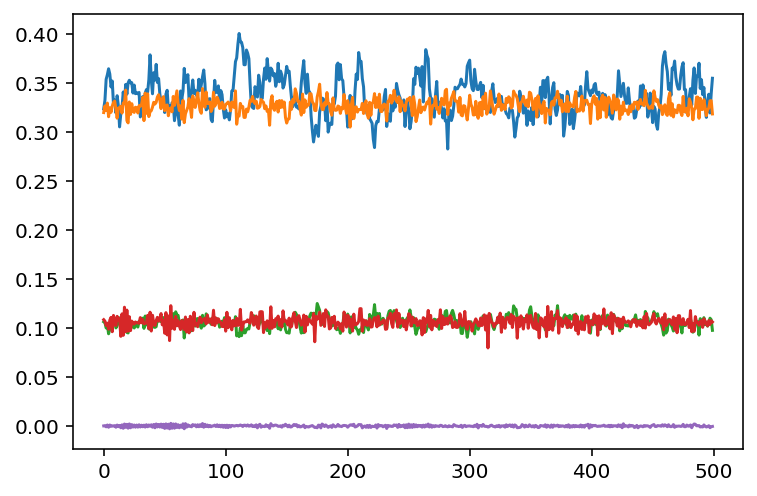

In [261]:
plt.plot(parameters)

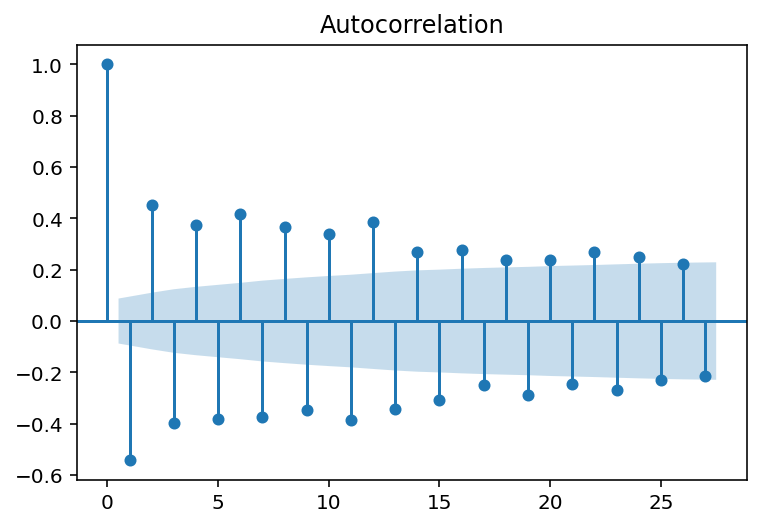

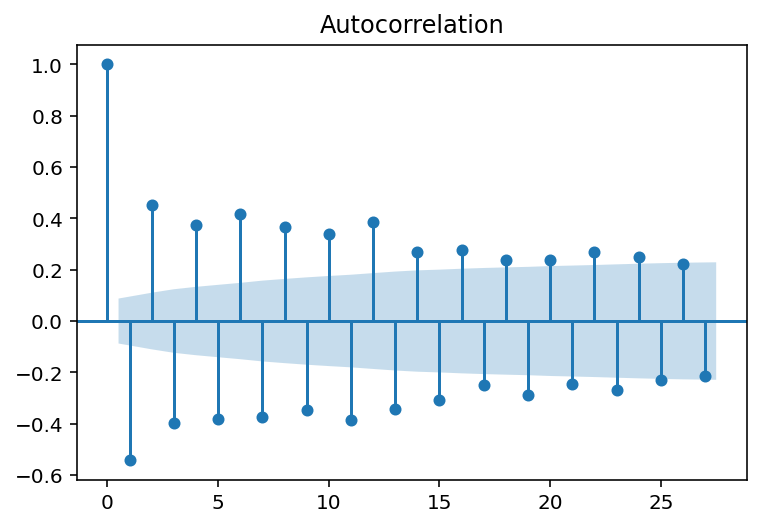

In [298]:
from statsmodels.graphics import tsaplots
tsaplots.plot_acf(parameters[:,4])

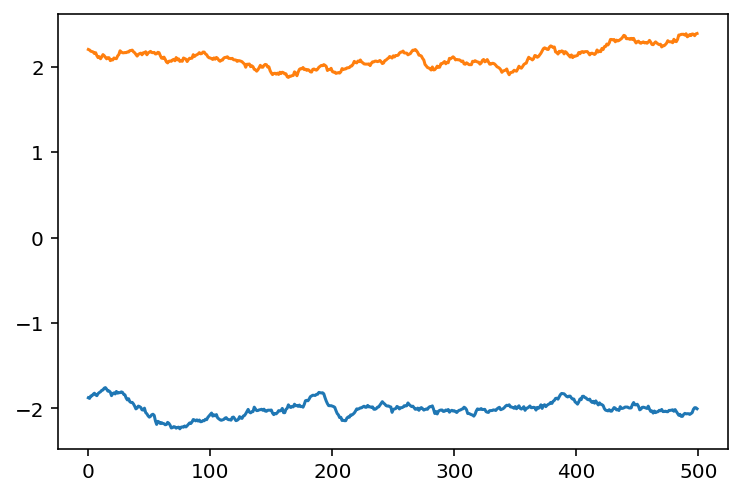

In [268]:
plt.plot(loglambdalist)
plt.plot(loggammalist)

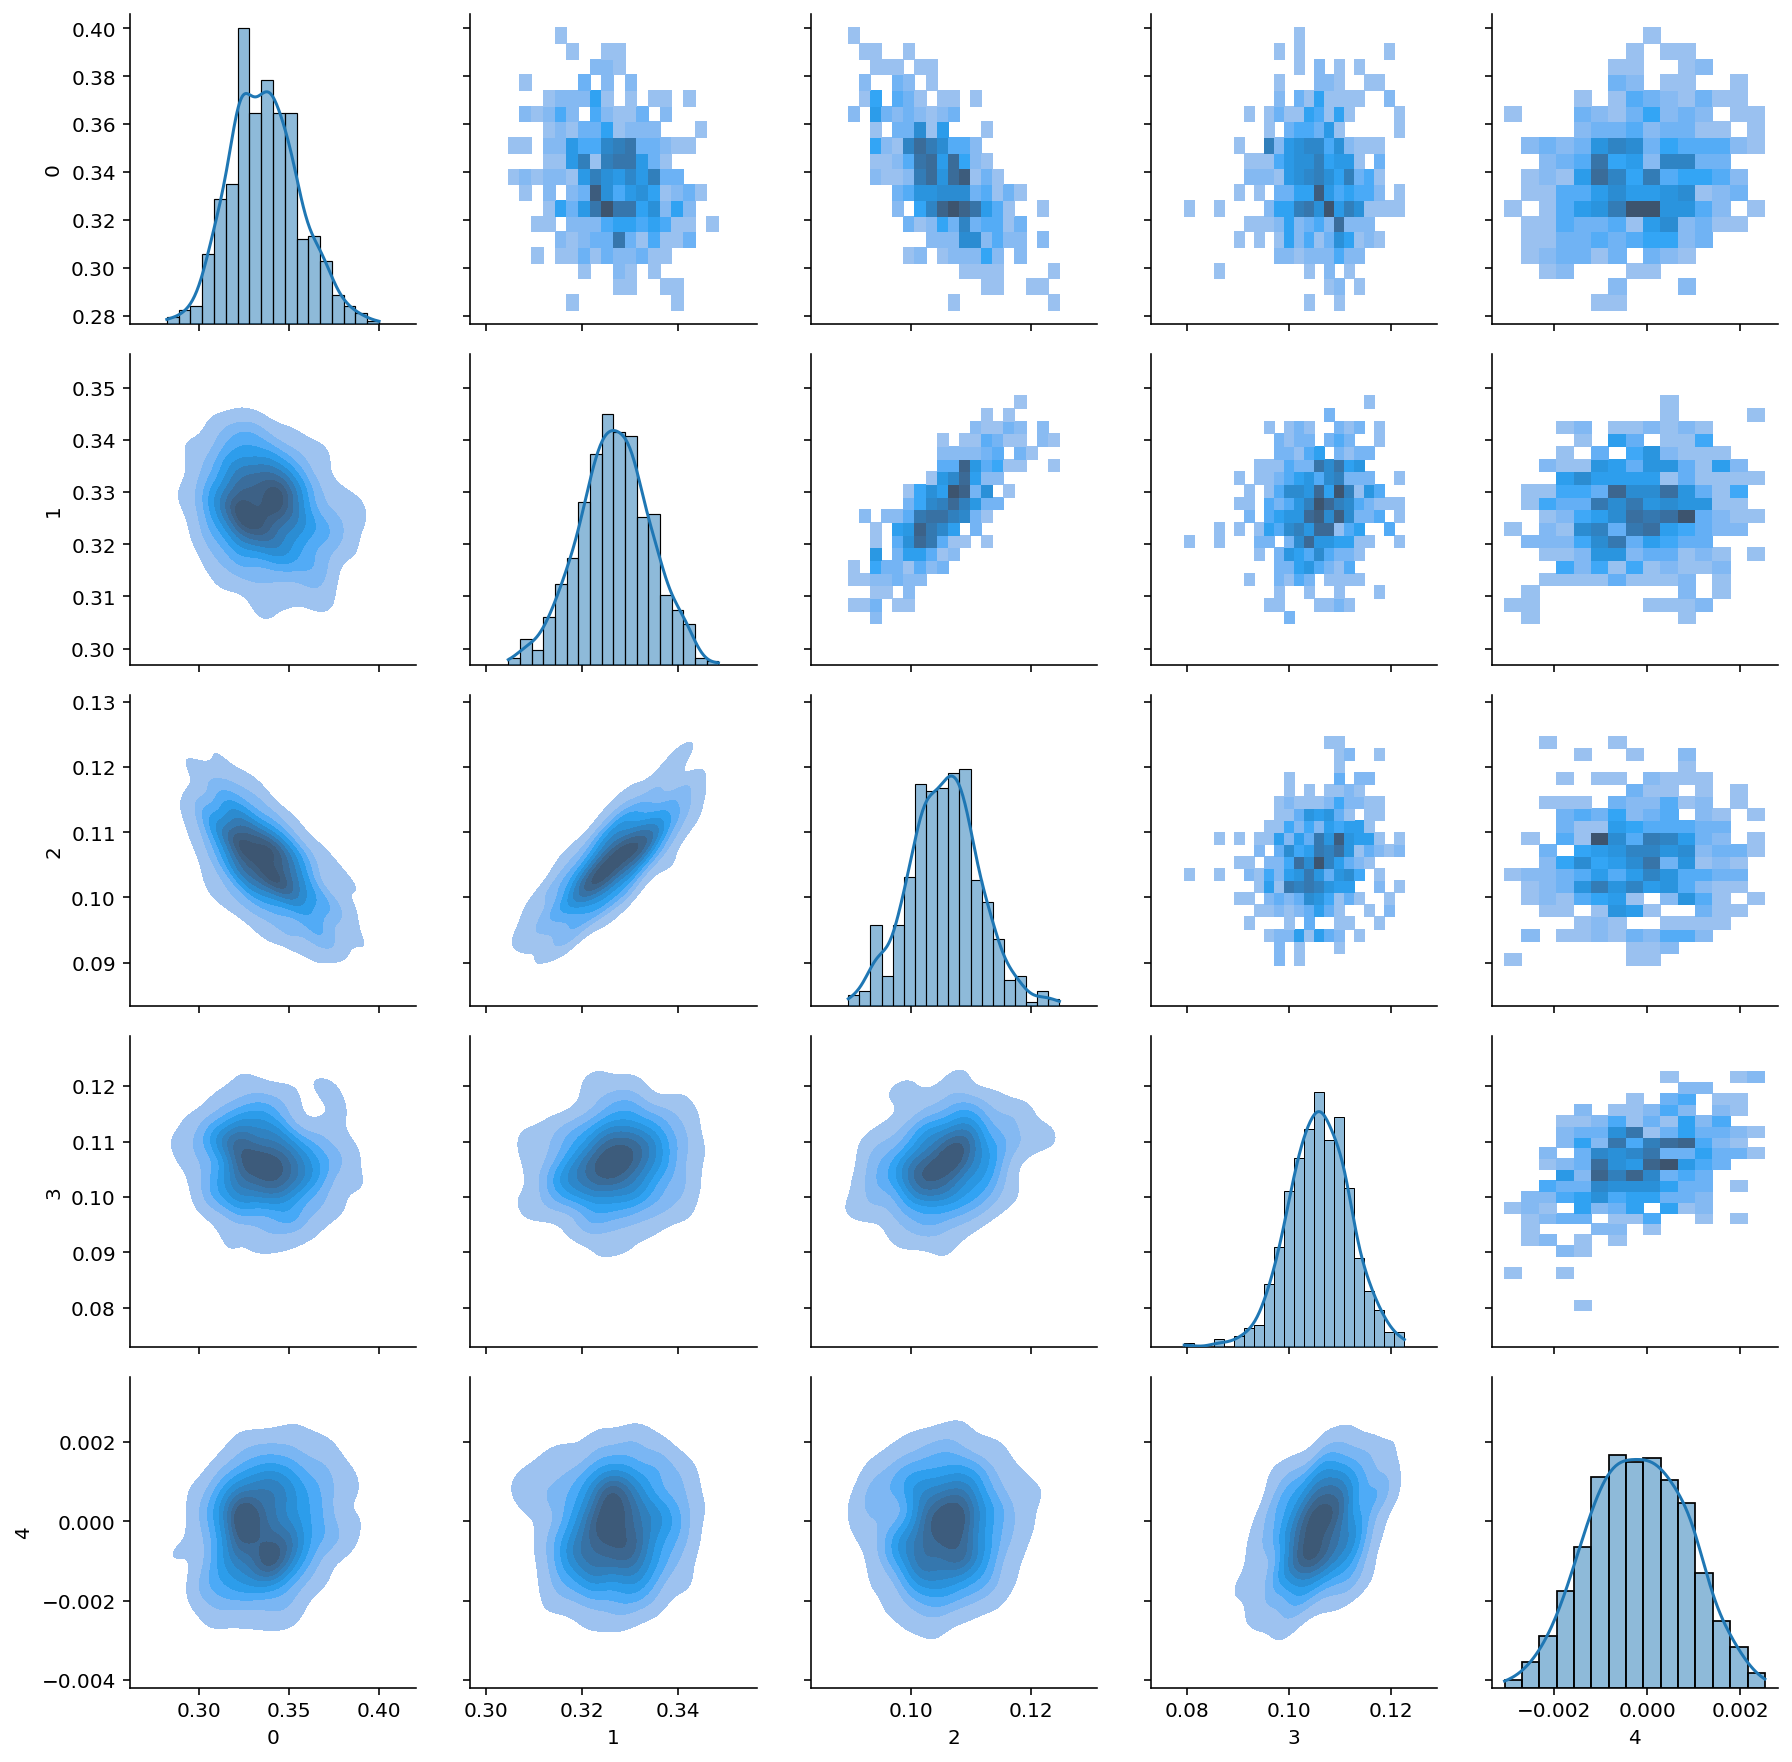

In [269]:
import seaborn as sns
import pandas as pd

g = sns.PairGrid(pd.DataFrame(parameters))
g.map_upper(sns.histplot)
g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 340.80it/s]


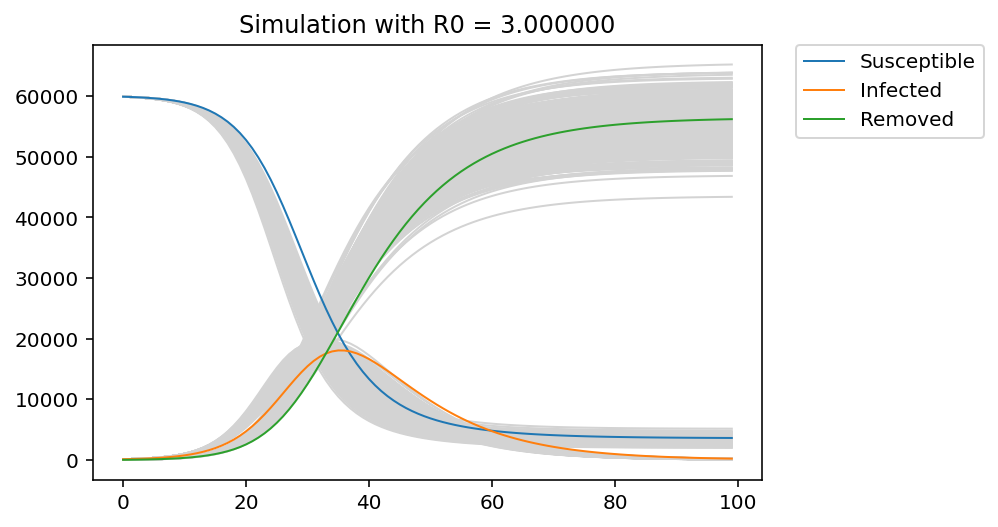

In [270]:
t_grid = np.linspace(0, data_size, data_size)  # uniformly spaced data? -> even though advantage is learning with not uniformly spaced data
z0 = [N - infected_0, infected_0, 0] # initial conditions

for j in tqdm(range(parameters.shape[0])):
    #simul_yy =  odeint(SIR_diffparam, z0, t_grid, args=tuple([np.median(parameters[:,i]) for i in range(parameters.shape[1])]))
    simul_yy =  odeint(SIR_diffparam, z0, t_grid, args=tuple(parameters[j]))
    plot_traj_gray(simul_yy)

true_yy = odeint(SIR, z0, t_grid, args=(beta, gamma))  # potrebbe aver senso tenerli in memoria se è lento
plot_traj(true_yy)

    
plt.show()

In [300]:
from scipy.stats import wilcoxon, mannwhitneyu, kruskal

kruskal(parameters[:,0],parameters[:,1])

KruskalResult(statistic=83.82784681671211, pvalue=5.397909252609818e-20)

In [290]:
import arviz as az

az.ess(parameters[:,3])

1349.4850021680093

<AxesSubplot:title={'center':'x'}>

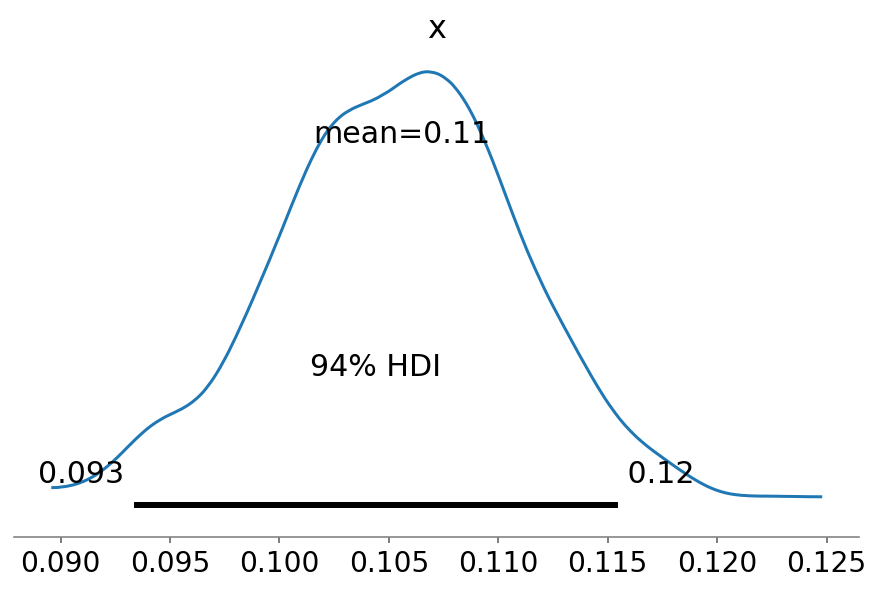

In [301]:
az.plot_posterior(parameters[:,2])

In [292]:
az.hdi(parameters[:,3])

array([0.09405002, 0.11669208])

In [286]:
az.geweke(parameters[:,1])

array([[ 0.00000000e+00, -1.64208973e-01],
       [ 1.30000000e+01, -4.61754196e-02],
       [ 2.60000000e+01, -8.64034805e-02],
       [ 3.90000000e+01,  5.26903195e-02],
       [ 5.20000000e+01,  3.67750805e-02],
       [ 6.50000000e+01,  7.16670414e-02],
       [ 7.80000000e+01, -4.74545450e-02],
       [ 9.10000000e+01, -5.65898768e-02],
       [ 1.05000000e+02, -1.46051258e-01],
       [ 1.18000000e+02, -1.50536943e-01],
       [ 1.31000000e+02, -1.15881503e-01],
       [ 1.44000000e+02,  1.21121192e-01],
       [ 1.57000000e+02,  2.28425641e-01],
       [ 1.70000000e+02,  7.74480074e-02],
       [ 1.83000000e+02, -2.36786521e-01],
       [ 1.96000000e+02, -1.76138027e-01],
       [ 2.10000000e+02,  1.41970180e-02],
       [ 2.23000000e+02,  2.54258406e-01],
       [ 2.36000000e+02,  1.12873716e-01],
       [ 2.49000000e+02, -6.17482649e-02]])

<AxesSubplot:title={'center':'x'}, xlabel='Quantile', ylabel='MCSE for quantiles'>

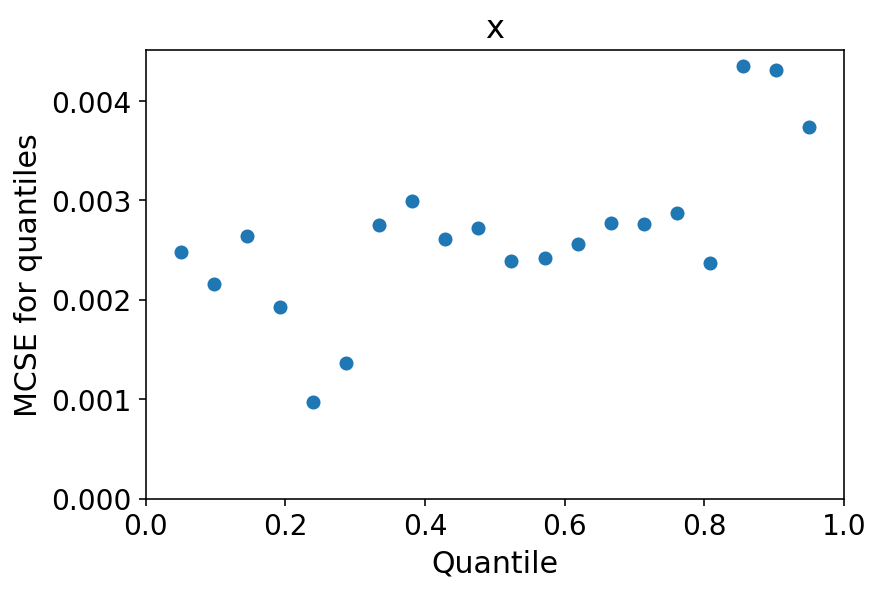

In [303]:
az.plot_mcse(parameters[:,0])

In [ ]:
# TO DO

# - simulation with only two parameters
# - go back to noisy simulation
# - thinning
# - weighted noise
# - CI for intensive therapy
# - sensitivity analysis!

# - understand why bayesian
# - sliding window for parameters estimation?
# - non observable states' estimation (through t-1?)
# - different dynamical systems interactions 

# - batch does not really make sense
# -> we always overestimate